In [2]:
import numpy as np, uproot as ur, awkward as ak, pandas as pd
import matplotlib.pyplot as plt
import os, sys
import pickle
import scipy.stats as st
from collections import defaultdict
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from scipy.stats import poisson, norm
from scipy.spatial import ConvexHull


import mplhep as hep
plt.figure()
hep.style.use("CMS")
plt.close()

def gaus(x, amp, mean, sigma):
    return amp * np.exp( -(x - mean)**2 / (2*sigma**2) ) 

def phi_reconstruct(x, y, z):
    return np.degrees(np.arctan2(y, x))
    
def theta_reconstruct(x, y, z):
    return np.degrees(np.arccos(abs(z)/np.sqrt(x**2+y**2+z**2)))

def theta_x(x, y, z):
    return x/z

def theta_y(x, y, z):
    return y/z

def phi_reconstruct(x, y, z):
    return np.degrees(np.arctan2(y, x))

def theta_x_y(x, y, z):
    data = np.concatenate((np.array(x)[:, np.newaxis], 
                           np.array(y)[:, np.newaxis], 
                           np.array(z)[:, np.newaxis]), 
                          axis=1)
    datamean = data.mean(axis=0)
    centered_data = data - datamean

    _, _, vv = np.linalg.svd(centered_data)
    direction_vector = vv[0]
    if direction_vector[2] > 0:
        direction_vector *= -1
        
    x_vec, y_vec, z_vec = direction_vector
    
    tanx = theta_x(x_vec, y_vec, z_vec)
    tany = theta_y(x_vec, y_vec, z_vec)
    
    return tanx, tany

def vector_angle_reconstruct(x, y, z): # Cell hit positions from detector, 
    data = np.concatenate((np.array(x)[:, np.newaxis], 
                           np.array(y)[:, np.newaxis], 
                           np.array(z)[:, np.newaxis]), 
                          axis=1)
    datamean = data.mean(axis=0)
    centered_data = data - datamean

    _, _, vv = np.linalg.svd(centered_data)
    direction_vector = vv[0]
    if direction_vector[2] > 0:
        direction_vector *= -1
        
    x_vec, y_vec, z_vec = direction_vector
    
    theta = theta_reconstruct(x_vec, y_vec, z_vec)
    phi = phi_reconstruct(x_vec, y_vec, z_vec)
    
    return theta, phi

def poisson_to_Z(N, lam):
    N = np.asarray(N, dtype=float)
    lam = np.asarray(lam, dtype=float)
    # Poisson CDF
    p = np.where(N >= lam,
                 poisson.cdf(N, lam),
                 1.0 - poisson.cdf(N, lam))
    # sign convention
    s = np.sign(lam - N)
    
    return s * norm.ppf(p)

def compute_kde_density(data, bandwidth, positions, phi_shape):
    values = np.vstack([np.array(data)[:,1], np.array(data)[:,0]])
    kernel = st.gaussian_kde(values)
    kernel.set_bandwidth(bw_method=bandwidth)
    density = np.reshape(kernel(positions).T, phi_shape)
    total_events = len(data)
    bin_area = (phi_grid[1]-phi_grid[0]) * (theta_grid[1]-theta_grid[0])
    return density * total_events * bin_area  # Convert to estimated counts

In [3]:
import uproot 

arrays = {}
num = 4
acceptance = 1.5
positions_x = [0,0,0,0]
positions_y = [0,0,0,0]
positions_z = [1,-25,-50,-100]

simfile = 'training/128_model/free_merged.root'
with uproot.open(simfile+":events") as f:
    arrays['muon_sim']=f.arrays(filter_name=["Detector", "MuographyHits.energy", "MuographyHits.position.x", "MuographyHits.position.y", "MuographyHits.position.z", "MCParticles.momentum.x", "MCParticles.momentum.y", "MCParticles.momentum.z", "MCParticles.mass", "GNN_theta"])
datafile = 'training/128_model/target_merged.root'
with uproot.open(datafile+":events") as f:
    arrays['muon_data']=f.arrays(filter_name=["Detector", "MuographyHits.energy", "MuographyHits.position.x", "MuographyHits.position.y", "MuographyHits.position.z", "MCParticles.momentum.x", "MCParticles.momentum.y", "MCParticles.momentum.z", "MCParticles.mass", "GNN_theta"])


In [4]:
reco_data_angles = []
reco_sim_angles = []
energies = []
data_GNN = []
sim_GNN = []
sim_energies = []
data_energies = []
sim_theta = []
data_theta = []
def vector_angle_reconstruct_1(x, y, z): # Cell hit positions from detector, 
    data = np.concatenate((np.array(x)[:, np.newaxis], 
                           np.array(y)[:, np.newaxis], 
                           np.array(z)[:, np.newaxis]), 
                          axis=1)
    datamean = data.mean(axis=0)
    centered_data = data - datamean

    _, _, vv = np.linalg.svd(centered_data)
    direction_vector = vv[0]
    if direction_vector[2] > 0:
        direction_vector *= -1
        
    x_vec, y_vec, z_vec = direction_vector
    x_vec, y_vec, z_vec = [x[0]-x[1],y[0]-y[1],z[0]-z[1]]
    theta = theta_reconstruct(x_vec, y_vec, z_vec)
    phi = phi_reconstruct(x_vec, y_vec, z_vec)
    
    return theta, phi
    
for i in range(num):
    print(i)
    detector = arrays['muon_data']['Detector']
    data_energy = arrays['muon_data'][f'MuographyHits.energy'][detector==i]*1000
    
    y,x=np.histogram(ak.flatten(data_energy), bins=100, range=(0, 4))
    bc=(x[1:]+x[:-1])/2
    MIP=list(bc[y==max(y)])[0] 
    data_MIP_cut = data_energy > 0.5*MIP/1000
    data_cell_cut = ak.num(arrays['muon_data'][f'MuographyHits.energy'][detector==i][data_MIP_cut], axis=1) >= 2
    #data_cell_cut = [True if len(cells)>=2 else False for cells in arrays['muon_data'][f"MuographyHits.energy"][data_MIP_cut]]
    
    data_x = arrays['muon_data'][f'MuographyHits.position.x'][detector==i][np.array(data_cell_cut)]
    data_y = arrays['muon_data'][f'MuographyHits.position.y'][detector==i][np.array(data_cell_cut)]
    data_z = arrays['muon_data'][f'MuographyHits.position.z'][detector==i][np.array(data_cell_cut)]    
    reco_data_angle = np.array([vector_angle_reconstruct(np.array(xi,dtype=float), np.array(yi,dtype=float), np.array(zi,dtype=float)) for xi, yi, zi in zip(data_x,data_y,data_z)])
    #reco_data_angle_1 = np.array([vector_angle_reconstruct_1(np.array(xi,dtype=float), np.array(yi,dtype=float), np.array(zi,dtype=float)) for xi, yi, zi in zip(data_x,data_y,data_z)])
    reco_data_angles.append(reco_data_angle)

    mc_px = arrays['muon_data']["MCParticles.momentum.x"][detector==i][np.array(data_cell_cut)]
    mc_py = arrays['muon_data']["MCParticles.momentum.y"][detector==i][np.array(data_cell_cut)]
    mc_pz = arrays['muon_data']["MCParticles.momentum.z"][detector==i][np.array(data_cell_cut)]
    mc_theta = theta_reconstruct(mc_px,mc_py,mc_pz)
    mc_phi = phi_reconstruct(mc_px,mc_py,mc_pz)    
    data_theta.append(mc_theta)
    detector = arrays['muon_sim']['Detector']
    sim_energy = arrays['muon_sim'][f'MuographyHits.energy'][detector==i]*1000
    
    y,x=np.histogram(ak.flatten(sim_energy) ,bins=100, range=(0, 4))
    bc=(x[1:]+x[:-1])/2
    MIP=list(bc[y==max(y)])[0] 
    sim_MIP_cut = sim_energy > 0.5*MIP/1000
    sim_cell_cut = ak.num(arrays['muon_sim'][f'MuographyHits.energy'][detector==i][sim_MIP_cut], axis=1) >= 2
    
    sim_x = arrays['muon_sim'][f'MuographyHits.position.x'][detector==i][np.array(sim_cell_cut)]
    sim_y = arrays['muon_sim'][f'MuographyHits.position.y'][detector==i][np.array(sim_cell_cut)]
    sim_z = arrays['muon_sim'][f'MuographyHits.position.z'][detector==i][np.array(sim_cell_cut)]    
    sim_energies.append(ak.sum(arrays['muon_sim'][f'MuographyHits.energy'][detector==i][sim_MIP_cut][np.array(sim_cell_cut)],axis=-1))
    reco_sim_angle = np.array([vector_angle_reconstruct(np.array(xi,dtype=float), np.array(yi,dtype=float), np.array(zi,dtype=float)) for xi, yi, zi in zip(sim_x,sim_y,sim_z)])
    reco_sim_angles.append(reco_sim_angle)
    data_energies.append(ak.sum(arrays['muon_sim'][f'MuographyHits.energy'][detector==i][sim_MIP_cut][np.array(sim_cell_cut)],axis=-1))
    data_GNN.append(arrays['muon_sim'][f'GNN_theta'][detector==i][np.array(sim_cell_cut)])
    sim_GNN.append(arrays['muon_sim'][f'GNN_theta'][detector==i][np.array(sim_cell_cut)])
    mc_px = arrays['muon_sim']["MCParticles.momentum.x"][detector==i][np.array(sim_cell_cut)]
    mc_py = arrays['muon_sim']["MCParticles.momentum.y"][detector==i][np.array(sim_cell_cut)]
    mc_pz = arrays['muon_sim']["MCParticles.momentum.z"][detector==i][np.array(sim_cell_cut)]
    mc_mass = arrays['muon_sim']["MCParticles.mass"][detector==i][np.array(sim_cell_cut)]
    mc_theta = theta_reconstruct(mc_px,mc_py,mc_pz)
    mc_phi = phi_reconstruct(mc_px,mc_py,mc_pz)   
    mc_energy = np.sqrt(mc_px**2 + mc_py **2 + mc_pz**2 + mc_mass**2)
    energies.append(mc_energy)
    sim_theta.append(mc_theta)

0
1
2
3


/tmp/ipykernel_210789/3858097620.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  discrete_cmap = plt.cm.get_cmap('viridis', num_bins)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

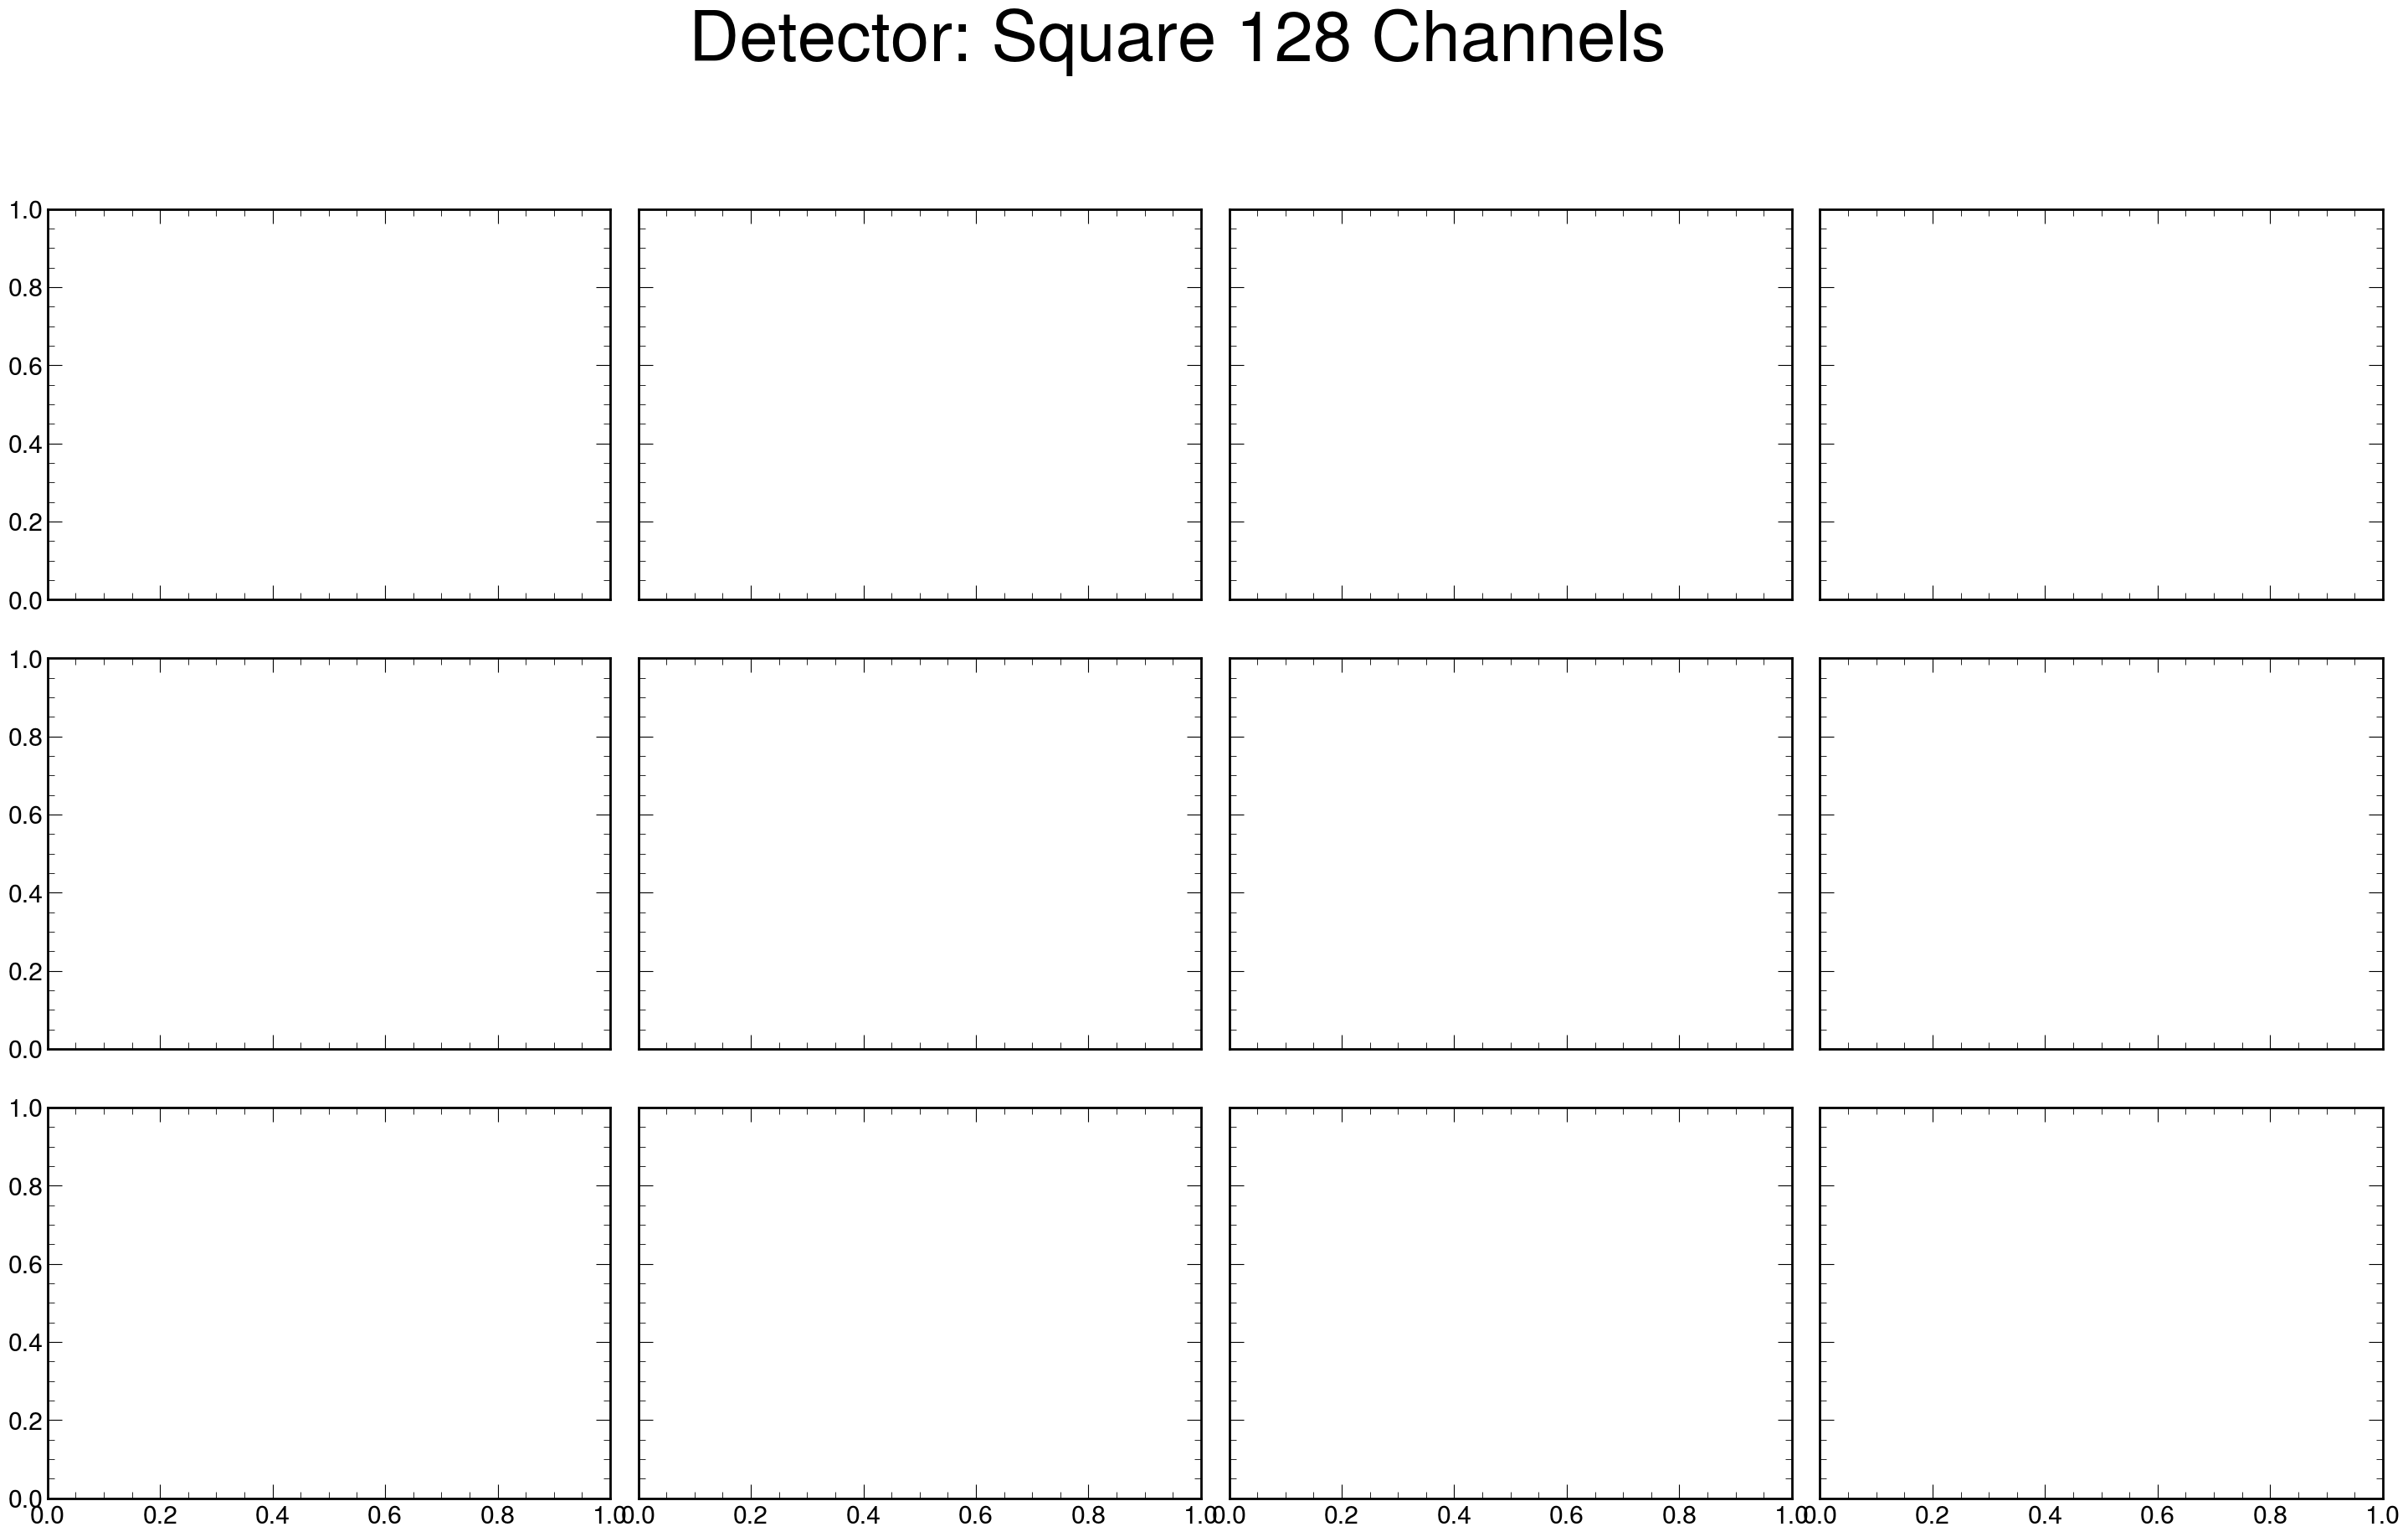

In [4]:

def project_point(r,x,y,z,x1,y1,z1):
    vx = x-x1
    vy = y-y1
    vz = z-z1
    theta = np.degrees(np.arccos(vz/np.sqrt(vx**2+vy**2+vz**2)))
    phi = phi_reconstruct(vx,vy,vz)
    d = np.sqrt(vx**2+vy**2+vz**2)
    radius = np.arcsin(r/d)
    return radius, theta, phi
    
colors = [
    (1, 0, 0),    # Red
    (0, 1, 0),    # Green
    (0, 0, 1),    # Blue
    (1, 1, 0),    # Yellow
    (0, 1, 1),    # Cyan
    (1, 0, 1),    # Magenta
    (0.5, 0, 0),  # Maroon
    (0, 0.5, 0),  # Dark Green
    (0, 0, 0.5),  # Navy
    (1, 0.5, 0)   # Orange
]
import matplotlib.colors as mcolors

# 2. Create the discrete colormap
cmap = mcolors.ListedColormap(colors)

target_pos = [
    [50, 0, -20],
    [0, 20, -5],
    [5, 0, -5],
    [-10, 0, -35],
    [0,40,-65],
    [0,-60,-20]
]
radius = [20, 5, 5, 5, 10, 10]

fig, ax = plt.subplots(3,num,figsize=(9*num,20),sharex=True,sharey=True)
fig.subplots_adjust(wspace=0.05,hspace=0.15)
plt.suptitle('Detector: Square 128 Channels',fontsize=60,y=1)
H_list = []
im_handles = [None, None, None]
theta_bin = np.linspace(5, 65, 15) #np.logspace(0.69897,1.7708520116421442, 15)
phi_bin = np.linspace(0, 360, 15)
num_bins = 10
discrete_cmap = plt.cm.get_cmap('viridis', num_bins)
for i in range(num):
    det_pos = (positions_x[i], positions_y[i], positions_z[i])
    reco_data_angle = reco_data_angles[i]
    reco_sim_angle = reco_sim_angles[i]
    T, xedges, yedges = np.histogram2d(np.mod(reco_sim_angle[:,1], 360),reco_sim_angle[:,0],bins=[phi_bin,theta_bin], range=((0, 360),(10,90)))

    H, xedges, yedges = np.histogram2d(np.mod(reco_data_angle[:,1], 360),reco_data_angle[:,0],bins=[phi_bin,theta_bin], range=((0, 360),(10,90)))
    H_list.append(H)
    plt.sca(ax[0,i%num])
    error = 1/np.sqrt(H.T)*100
    #T = np.where(error.T<20, T, 0)
    #H = np.where(error.T<20, H, 0)
    #plt.gca().add_patch(rect)
    im1 = plt.imshow(error, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               cmap=cmap, aspect='auto', vmin=0, vmax=100)
    im_handles[0] = im1
    #plt.colorbar(label='Counts')
    #plt.ylabel("Theta")
    plt.ylim(top=63)
    #plt.xlabel("Phi")
    plt.title(f'Detector {i}; {positions_x[i]},{positions_y[i]},{positions_z[i]} m')
    #plt.legend()
    plt.colorbar(label='Statistical Error')
    
    # Plot the Z-map
    plt.sca(ax[1, i%num])

    #plt.gca().add_patch(rect)
    Z = poisson_to_Z(H, T)
    Z = np.clip(Z,-10,10)
    im2 = plt.imshow(Z.T, origin='lower',
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               cmap='copper', aspect='auto',vmin=-5,vmax=5)
    im_handles[1] = im2
    #plt.colorbar(label='Significance Z')
    plt.ylim(top=63)
    #plt.ylabel("Theta")
    #plt.xlabel("Phi")
    plt.title(f'Tar/Free Tracks: {len(reco_data_angle)}/{len(reco_sim_angle)}')
    #plt.legend()
    for j, pos in enumerate(target_pos):
        rad, the, ph = project_point(radius[j],*pos,positions_x[i],positions_y[i],positions_z[i])
        #plt.scatter(ph+180, the, c='r',s=10)
        circle = plt.Circle((np.mod(ph+180, 360), the), np.rad2deg(rad), color='red', fill=False, linewidth=3, linestyle='--')
        ax[1, i%num].add_patch(circle)
        #print(f'Phi:{ph:.2f},  Theta:{the:.2f}')
        if -5<(ph+180)<365 and -5<the<70:
            plt.text(np.mod(ph+180, 360), the, f'C{j}', size=20, c='r')
    rad, the, ph = project_point(10,12,7,-25,positions_x[i],positions_y[i],positions_z[i])
    circle = plt.Circle((np.mod(ph+180, 360), the), np.rad2deg(rad), color='blue', fill=False, linewidth=3, linestyle='--')
    if -5<(ph+180)<365 and -5<the<70:
        plt.text(np.mod(ph+180, 360), the, f'B0', size=20, c='b')
    ax[1, i%num].add_patch(circle)
    
    rad, the, ph = project_point(5,-30,-30,-10,positions_x[i],positions_y[i],positions_z[i])
    circle = plt.Circle((np.mod(ph+180, 360), the), np.rad2deg(rad), color='blue', fill=False, linewidth=3, linestyle='--')
    if -5<(ph+180)<365 and -5<the<70:
        plt.text(np.mod(ph+180, 360), the, f'B1', size=20, c='b')
    ax[1, i%num].add_patch(circle)
    
    plt.colorbar(label=r'Significance $\sigma$')
    
    plt.sca(ax[2,i%num])

    sim_H, sim_xedges, sim_yedges = np.histogram2d(
        np.mod(reco_sim_angle[:,1], 360), reco_sim_angle[:,0], bins=[phi_bin,theta_bin], range=((0, 360),(10,90))
    )
    
    # Data histogram (note: should use reco_data_angle for both axes, not mix with reco_sim_angle[:,0]?)
    data_H, _, _ = np.histogram2d(
        np.mod(reco_data_angle[:,1], 360), reco_data_angle[:,0], bins=[phi_bin,theta_bin], range=((0, 360),(10,90))
    )
    #sim_H = np.where(error.T<20, sim_H, 0)
    #data_H = np.where(error.T<20, data_H, 0)
    # Avoid divide-by-zero with masking
    #ratio = np.divide(data_H, sim_H, out=np.zeros_like(data_H, dtype=float), where=sim_H>0)
    ratio = np.divide(data_H, sim_H)
    # Plot the ratio
    im3 = plt.imshow(
        ratio.T,                      # transpose so x=first axis, y=second
        origin="lower", 
        extent=[sim_xedges[0], sim_xedges[-1], sim_yedges[0], sim_yedges[-1]],
        aspect="auto",
        cmap='copper',
        vmin=0, vmax=2
    )
    im_handles[2] = im3
    #plt.colorbar(label=r'Transmission')
    plt.ylim(top=63)
    #plt.ylabel("Theta")
    #plt.xlabel("Phi")
   # your sphere center
    for j, pos in enumerate(target_pos):
        rad, the, ph = project_point(radius[j],*pos,positions_x[i],positions_y[i],positions_z[i])
        #plt.scatter(ph+180, the, c='r',s=10)
        circle = plt.Circle((np.mod(ph+180, 360), the), np.rad2deg(rad), color='red', fill=False, linewidth=3, linestyle='--')
        if -5<(ph+180)<365 and -5<the<70:
            plt.text(np.mod(ph+180, 360), the, f'C{j}', size=20, c='r')
        ax[2, i%num].add_patch(circle)
    #plt.legend()
    rad, the, ph = project_point(10,12,7,-25,positions_x[i],positions_y[i],positions_z[i])
    circle = plt.Circle((np.mod(ph+180, 360), the), np.rad2deg(rad), color='blue', fill=False, linewidth=3, linestyle='--')
    if -5<(ph+180)<365 and -5<the<70:
        plt.text(np.mod(ph+180, 360), the, f'B0', size=20, c='b')
    ax[2, i%num].add_patch(circle)
    
    rad, the, ph = project_point(5,-30,-30,-10,positions_x[i],positions_y[i],positions_z[i])
    circle = plt.Circle((np.mod(ph+180, 360), the), np.rad2deg(rad), color='blue', fill=False, linewidth=3, linestyle='--')
    if -5<(ph+180)<365 and -5<the<70:
        plt.text(np.mod(ph+180, 360), the, f'B1', size=20, c='b')
    ax[2, i%num].add_patch(circle)
    
    plt.colorbar(label='Transmission')
    plt.xlabel('Phi (degrees)', fontsize=35, labelpad=20)

ax[0, 0].set_ylabel('Theta (degrees)', fontsize=35, labelpad=20)
ax[1, 0].set_ylabel('Theta (degrees)', fontsize=35, labelpad=20)
ax[2, 0].set_ylabel('Theta (degrees)', fontsize=35, labelpad=20)

#ax[-1, -1].set_xlabel('Phi (degrees)', fontsize=35, labelpad=20)
H_min = min(h.min() for h in H_list)
H_max = max(h.max() for h in H_list)
#for row, im in enumerate(im_handles):
#    fig.colorbar(im, ax=ax[row,:], orientation='vertical', label=['Statistical Error','Significance Z','Transmission'][row], pad=0.01)
plt.show()

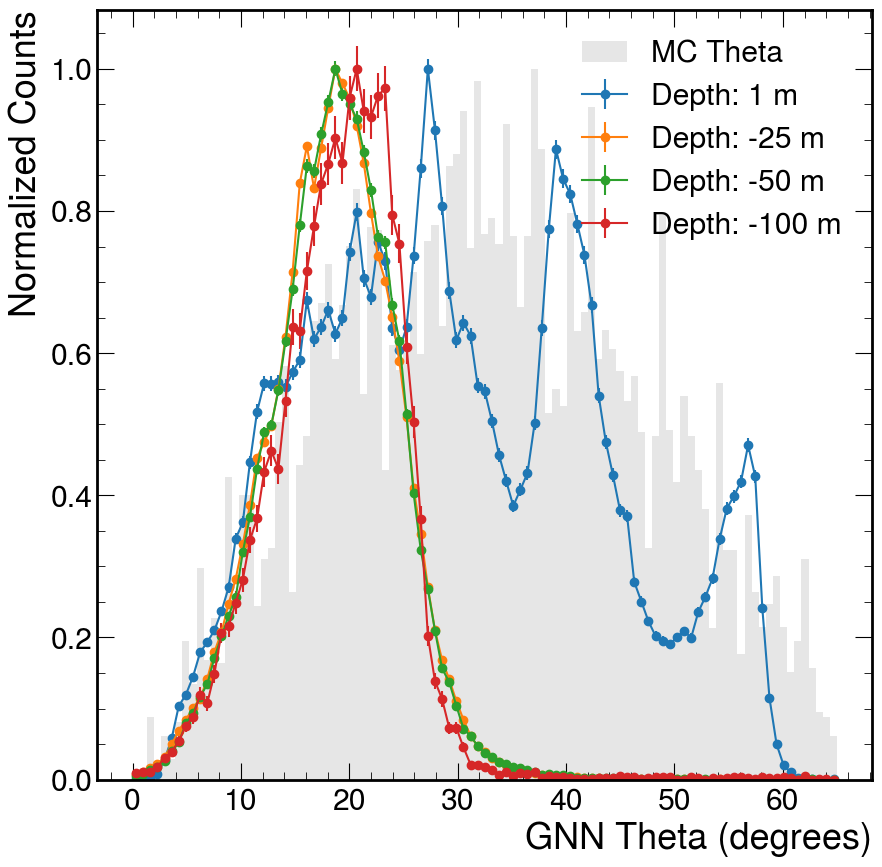

In [5]:
bins, edges = np.histogram(mc_theta,bins=np.linspace(0,65,100))
centers = edges[1:]/2 + edges[:-1]/2
plt.bar(centers, bins/max(bins), width=edges[1]-edges[0], label='MC Theta' ,facecolor='0.9')
for i in range(4):
    bins, edges = np.histogram(data_GNN[i],bins=np.linspace(0,65,100))
    centers = edges[1:]/2 + edges[:-1]/2
    plt.errorbar(centers,bins/max(bins),yerr=np.sqrt(bins)/max(bins),fmt='-o',label=rf'Depth: {positions_z[i]} m')
plt.xlabel("GNN Theta (degrees)")
plt.ylabel('Normalized Counts')
plt.legend()

/tmp/ipykernel_211910/3890771162.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  discrete_cmap = plt.cm.get_cmap('viridis', num_bins)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

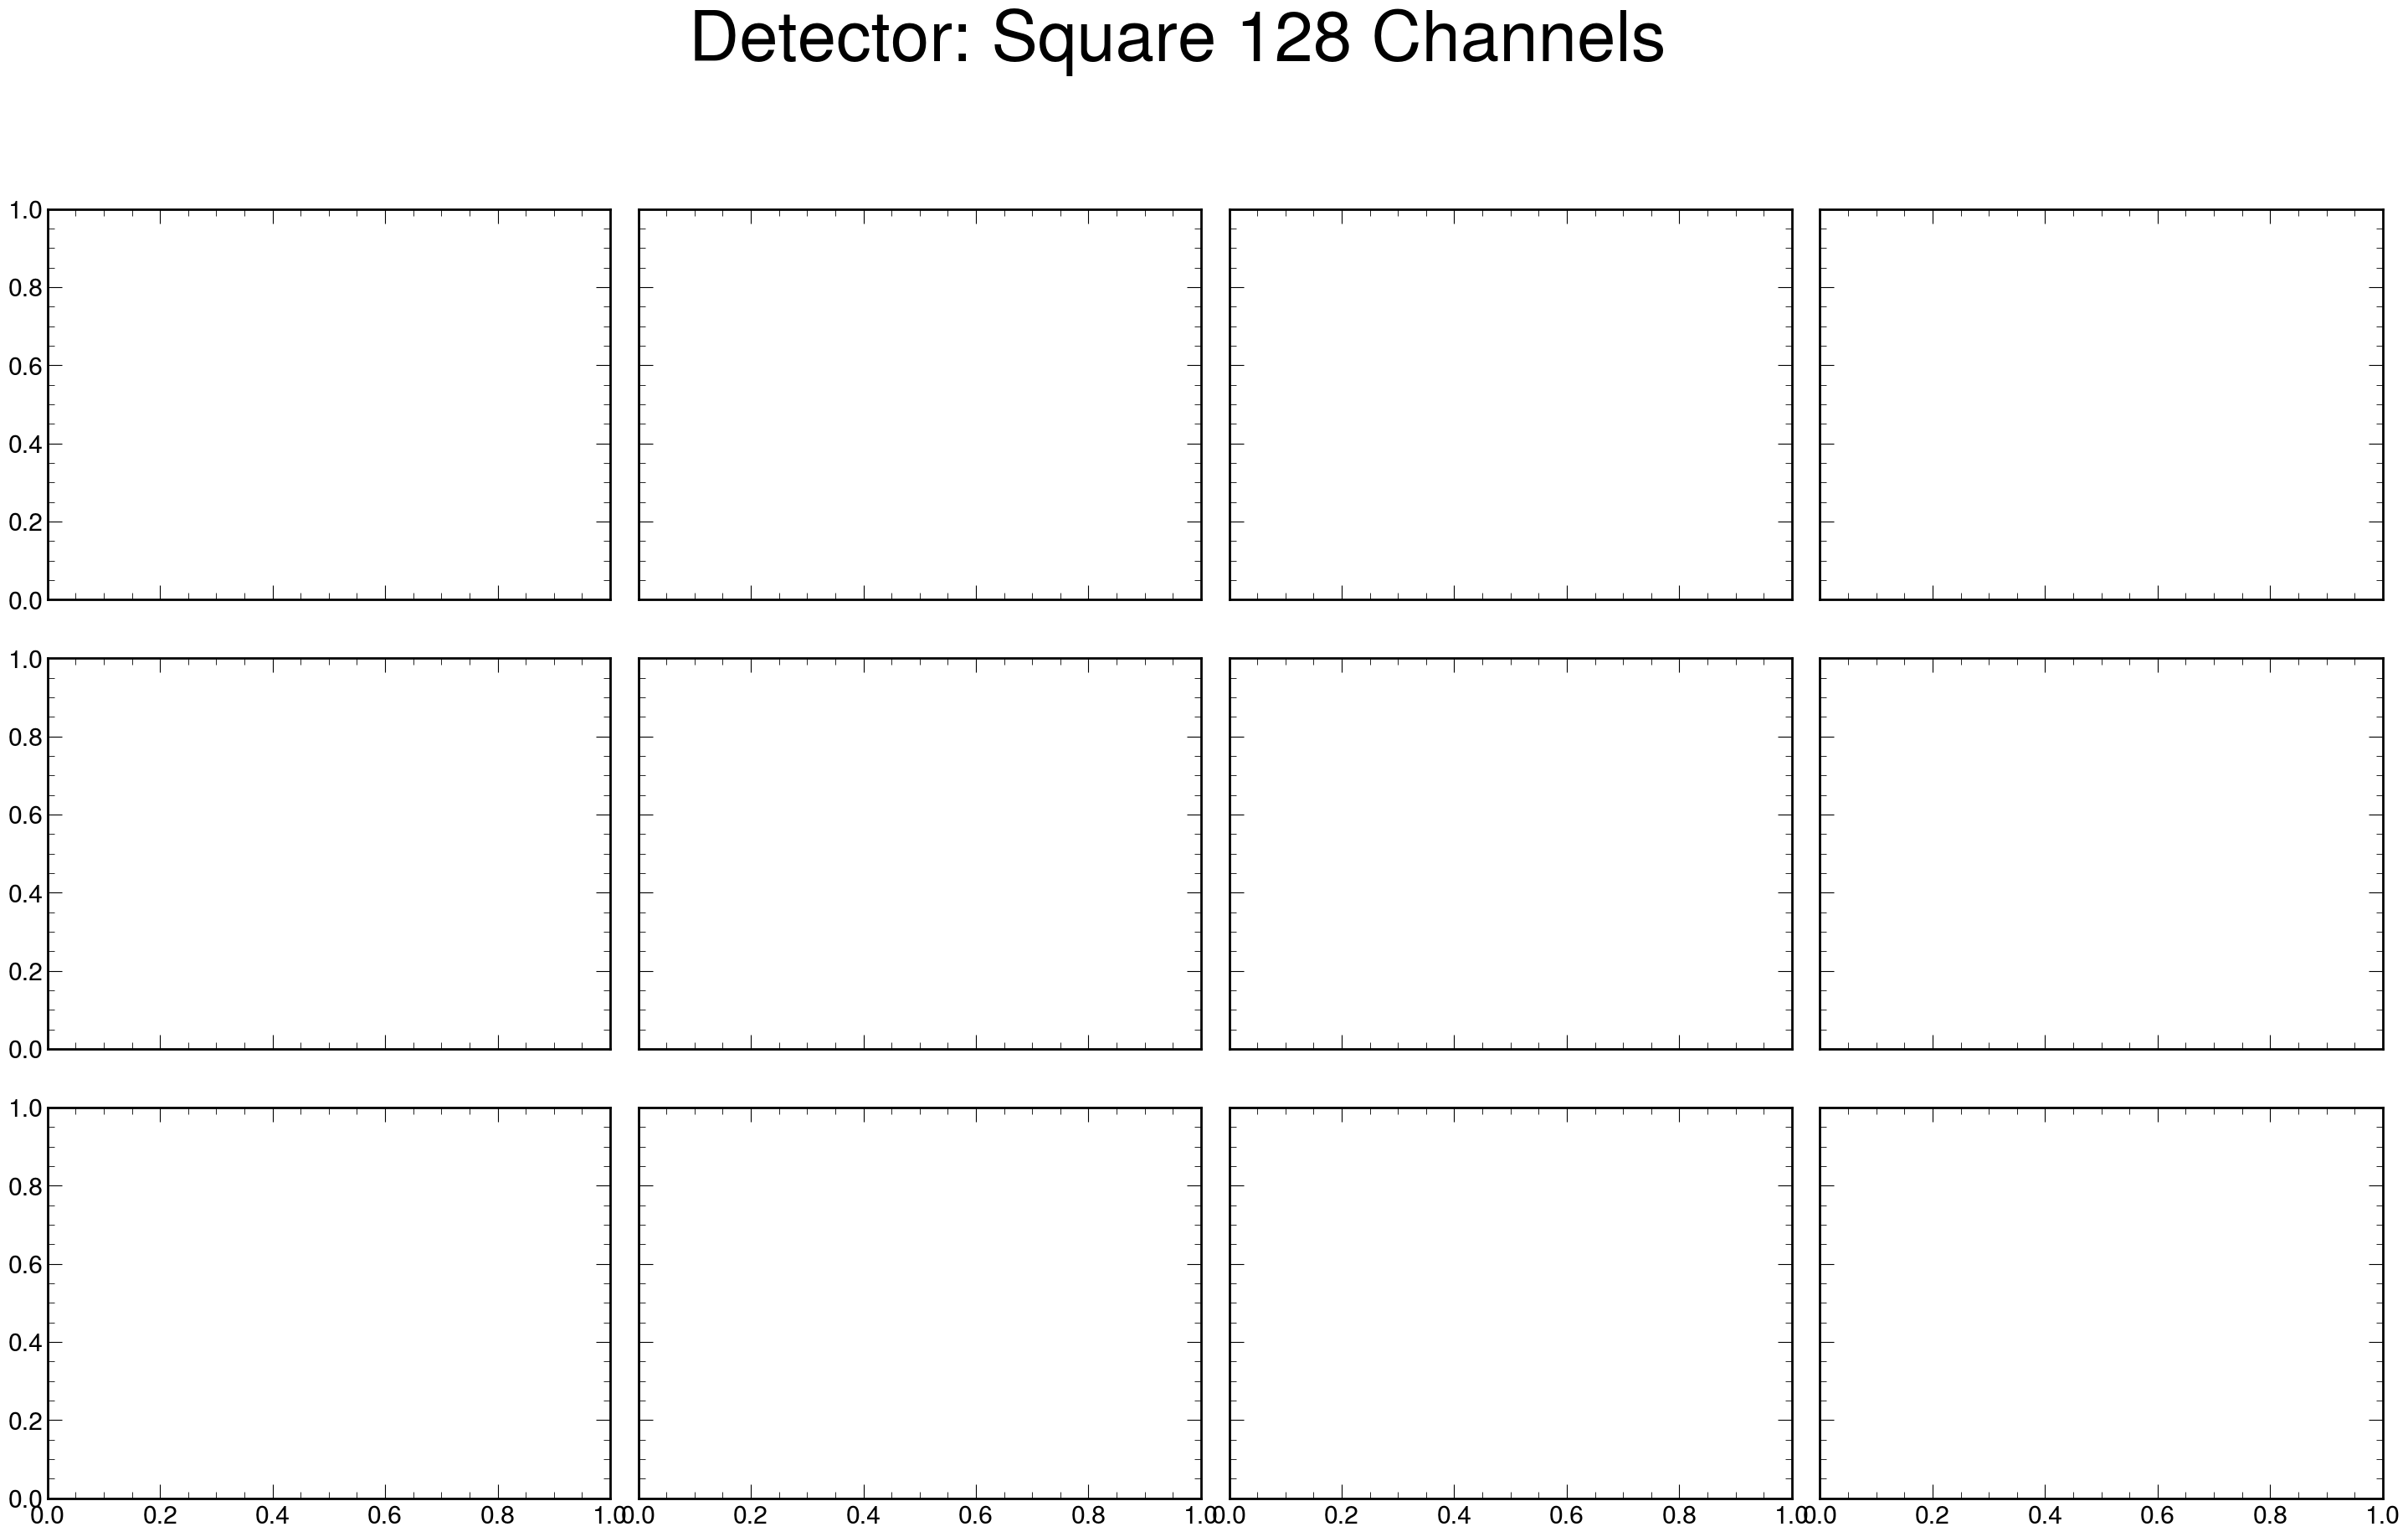

In [6]:
def project_point(r,x,y,z,x1,y1,z1):
    vx = x-x1
    vy = y-y1
    vz = z-z1
    theta = np.degrees(np.arccos(vz/np.sqrt(vx**2+vy**2+vz**2)))
    phi = phi_reconstruct(vx,vy,vz)
    d = np.sqrt(vx**2+vy**2+vz**2)
    radius = np.arcsin(r/d)
    return radius, theta, phi
    
colors = [
    (1, 0, 0),    # Red
    (0, 1, 0),    # Green
    (0, 0, 1),    # Blue
    (1, 1, 0),    # Yellow
    (0, 1, 1),    # Cyan
    (1, 0, 1),    # Magenta
    (0.5, 0, 0),  # Maroon
    (0, 0.5, 0),  # Dark Green
    (0, 0, 0.5),  # Navy
    (1, 0.5, 0)   # Orange
]
import matplotlib.colors as mcolors

# 2. Create the discrete colormap
cmap = mcolors.ListedColormap(colors)

target_pos = [
    [50, 0, -20],
    [0, 20, -5],
    [5, 0, -5],
    [-10, 0, -35],
    [0,40,-65],
    [0,-60,-20]
]
radius = [20, 5, 5, 5, 10, 10]

fig, ax = plt.subplots(3,num,figsize=(9*num,20),sharex=True,sharey=True)
fig.subplots_adjust(wspace=0.05,hspace=0.15)
plt.suptitle('Detector: Square 128 Channels',fontsize=60,y=1)
H_list = []
im_handles = [None, None, None]
theta_bin = np.linspace(5, 65, 15) #np.logspace(0.69897,1.7708520116421442, 15)
phi_bin = np.linspace(0, 360, 15)
num_bins = 10
discrete_cmap = plt.cm.get_cmap('viridis', num_bins)
for i in range(num):
    det_pos = (positions_x[i], positions_y[i], positions_z[i])
    reco_data_angle = reco_data_angles[i]
    reco_sim_angle = reco_sim_angles[i]
    T, xedges, yedges = np.histogram2d(np.mod(reco_sim_angle[:,1], 360),np.array(sim_GNN[i]),bins=[phi_bin,theta_bin], range=((0, 360),(10,90)))

    H, xedges, yedges = np.histogram2d(np.mod(reco_data_angle[:,1], 360),np.array(data_GNN[i]),bins=[phi_bin,theta_bin], range=((0, 360),(10,90)))
    H_list.append(H)
    plt.sca(ax[0,i%num])
    error = 1/np.sqrt(H.T)*100
    #T = np.where(error.T<20, T, 0)
    #H = np.where(error.T<20, H, 0)
    #plt.gca().add_patch(rect)
    im1 = plt.imshow(error, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               cmap=cmap, aspect='auto', vmin=0, vmax=100)
    im_handles[0] = im1
    #plt.colorbar(label='Counts')
    #plt.ylabel("Theta")
    plt.ylim(top=63)
    #plt.xlabel("Phi")
    plt.title(f'Detector {i}; {positions_x[i]},{positions_y[i]},{positions_z[i]} m')
    #plt.legend()
    plt.colorbar(label='Statistical Error')
    
    # Plot the Z-map
    plt.sca(ax[1, i%num])

    #plt.gca().add_patch(rect)
    Z = poisson_to_Z(H, T)
    Z = np.clip(Z,-10,10)
    im2 = plt.imshow(Z.T, origin='lower',
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               cmap='copper', aspect='auto',vmin=-5,vmax=5)
    im_handles[1] = im2
    #plt.colorbar(label='Significance Z')
    plt.ylim(top=63)
    #plt.ylabel("Theta")
    #plt.xlabel("Phi")
    plt.title(f'Tar/Free Tracks: {len(data_GNN[i])}/{len(sim_GNN[i])}')
    #plt.legend()
    for j, pos in enumerate(target_pos):
        rad, the, ph = project_point(radius[j],*pos,positions_x[i],positions_y[i],positions_z[i])
        #plt.scatter(ph+180, the, c='r',s=10)
        circle = plt.Circle((np.mod(ph+180, 360), the), np.rad2deg(rad), color='red', fill=False, linewidth=3, linestyle='--')
        ax[1, i%num].add_patch(circle)
        #print(f'Phi:{ph:.2f},  Theta:{the:.2f}')
        if -5<(ph+180)<365 and -5<the<70:
            plt.text(np.mod(ph+180, 360), the, f'C{j}', size=20, c='r')
    rad, the, ph = project_point(10,12,7,-25,positions_x[i],positions_y[i],positions_z[i])
    circle = plt.Circle((np.mod(ph+180, 360), the), np.rad2deg(rad), color='blue', fill=False, linewidth=3, linestyle='--')
    if -5<(ph+180)<365 and -5<the<70:
        plt.text(np.mod(ph+180, 360), the, f'B0', size=20, c='b')
    ax[1, i%num].add_patch(circle)
    
    rad, the, ph = project_point(5,-30,-30,-10,positions_x[i],positions_y[i],positions_z[i])
    circle = plt.Circle((np.mod(ph+180, 360), the), np.rad2deg(rad), color='blue', fill=False, linewidth=3, linestyle='--')
    if -5<(ph+180)<365 and -5<the<70:
        plt.text(np.mod(ph+180, 360), the, f'B1', size=20, c='b')
    ax[1, i%num].add_patch(circle)
    
    plt.colorbar(label=r'Significance $\sigma$')
    
    plt.sca(ax[2,i%num])

    sim_H, sim_xedges, sim_yedges = np.histogram2d(
        np.mod(reco_sim_angle[:,1], 360), np.array(sim_GNN[i]), bins=[phi_bin,theta_bin], range=((0, 360),(10,90))
    )
    

    data_H, _, _ = np.histogram2d(
        np.mod(reco_data_angle[:,1], 360), np.array(data_GNN[i]), bins=[phi_bin,theta_bin], range=((0, 360),(10,90))
    )
    #sim_H = np.where(error.T<20, sim_H, 0)
    #data_H = np.where(error.T<20, data_H, 0)
    # Avoid divide-by-zero with masking
    #ratio = np.divide(data_H, sim_H, out=np.zeros_like(data_H, dtype=float), where=sim_H>0)
    ratio = np.divide(data_H, sim_H)
    # Plot the ratio
    im3 = plt.imshow(
        ratio.T,                      # transpose so x=first axis, y=second
        origin="lower", 
        extent=[sim_xedges[0], sim_xedges[-1], sim_yedges[0], sim_yedges[-1]],
        aspect="auto",
        cmap='copper',
        vmin=0, vmax=2
    )
    im_handles[2] = im3
    #plt.colorbar(label=r'Transmission')
    plt.ylim(top=63)
    #plt.ylabel("Theta")
    #plt.xlabel("Phi")
   # your sphere center
    for j, pos in enumerate(target_pos):
        rad, the, ph = project_point(radius[j],*pos,positions_x[i],positions_y[i],positions_z[i])
        #plt.scatter(ph+180, the, c='r',s=10)
        circle = plt.Circle((np.mod(ph+180, 360), the), np.rad2deg(rad), color='red', fill=False, linewidth=3, linestyle='--')
        if -5<(ph+180)<365 and -5<the<70:
            plt.text(np.mod(ph+180, 360), the, f'C{j}', size=20, c='r')
        ax[2, i%num].add_patch(circle)
    #plt.legend()
    rad, the, ph = project_point(10,12,7,-25,positions_x[i],positions_y[i],positions_z[i])
    circle = plt.Circle((np.mod(ph+180, 360), the), np.rad2deg(rad), color='blue', fill=False, linewidth=3, linestyle='--')
    if -5<(ph+180)<365 and -5<the<70:
        plt.text(np.mod(ph+180, 360), the, f'B0', size=20, c='b')
    ax[2, i%num].add_patch(circle)
    
    rad, the, ph = project_point(5,-30,-30,-10,positions_x[i],positions_y[i],positions_z[i])
    circle = plt.Circle((np.mod(ph+180, 360), the), np.rad2deg(rad), color='blue', fill=False, linewidth=3, linestyle='--')
    if -5<(ph+180)<365 and -5<the<70:
        plt.text(np.mod(ph+180, 360), the, f'B1', size=20, c='b')
    ax[2, i%num].add_patch(circle)
    
    plt.colorbar(label='Transmission')
    plt.xlabel('Reco Phi (degrees)', fontsize=35, labelpad=20)

ax[0, 0].set_ylabel('GNN Theta (degrees)', fontsize=35, labelpad=20)
ax[1, 0].set_ylabel('GNN Theta (degrees)', fontsize=35, labelpad=20)
ax[2, 0].set_ylabel('GNN Theta (degrees)', fontsize=35, labelpad=20)

#ax[-1, -1].set_xlabel('Phi (degrees)', fontsize=35, labelpad=20)
H_min = min(h.min() for h in H_list)
H_max = max(h.max() for h in H_list)
#for row, im in enumerate(im_handles):
#    fig.colorbar(im, ax=ax[row,:], orientation='vertical', label=['Statistical Error','Significance Z','Transmission'][row], pad=0.01)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Example input variables (replace with your data) ---
# positions_x, positions_y, positions_z : arrays of detector positions
# reco_data_angles, reco_sim_angles : lists of arrays [theta, phi] for each detector
# target_pos : list of [x,y,z] target positions
# radius : radius for each target
# num : number of detectors
# poisson_to_Z : function to convert counts to Z
# phi_reconstruct : function from your original code

# --- Binning ---
theta_bin = np.linspace(5, 65, 20)       # theta edges
phi_bin = np.linspace(0, 360, 20)        # phi edges in degrees
phi_edges_rad = np.radians(phi_bin)      # convert to radians

# --- Figure setup ---
fig, ax = plt.subplots(3, num, figsize=(9*num, 20), subplot_kw={'projection': 'polar'})
fig.subplots_adjust(wspace=0.15, hspace=0.25)
cmap = mcolors.ListedColormap(colors)

for i in range(num):
    det_pos = (positions_x[i], positions_y[i], positions_z[i])
    reco_data_angle = reco_data_angles[i]
    reco_sim_angle = reco_sim_angles[i]

    # Convert phi to radians
    phi_data_rad = np.radians(np.mod(reco_data_angle[:,1], 360))
    theta_data = reco_data_angle[:,0]

    phi_sim_rad = np.radians(np.mod(reco_sim_angle[:,1], 360))
    theta_sim = reco_sim_angle[:,0]

    # 1) Statistical Error
    H, _, _ = np.histogram2d(phi_data_rad, theta_data, bins=[phi_edges_rad, theta_bin])
    H_sim, _, _ = np.histogram2d(phi_sim_rad, theta_sim, bins=[phi_edges_rad, theta_bin])
    
    error = 1 / np.sqrt(H_sim.T) * 100

    # pcolormesh (edges)
    pc = ax[0, i].pcolormesh(phi_edges_rad, theta_bin, error.T, cmap=cmap, shading='auto', alpha=0.9)

    # contour (use centers)

    ax[0, i].set_theta_direction(-1)
    ax[0, i].set_ylim(0, 70)
    ax[0, i].grid(True, linestyle='--', alpha=0.5)
    plt.colorbar(pc, ax=ax[0, i], pad=0.1, label='Statistical Error')

    # 2) Z-map
    
    Z = poisson_to_Z(H, H_sim)
    Z = np.clip(Z.T, -5, 5)

    pc = ax[1, i].pcolormesh(phi_edges_rad, theta_bin, Z, cmap='copper', shading='auto', alpha=0.9)
    ax[1, i].set_theta_direction(-1)
    ax[1, i].set_ylim(0, 70)
    ax[1, i].grid(True, linestyle='--', alpha=0.5)
    plt.colorbar(pc, ax=ax[1, i], pad=0.1, label=r'Significance $\sigma$')


    # 3) Data / Simulation Ratio
    ratio = np.divide(H, H_sim, out=np.zeros_like(H, dtype=float), where=H_sim>0)
    pc = ax[2, i].pcolormesh(phi_edges_rad, theta_bin, ratio.T, cmap='copper', shading='auto', alpha=0.9, vmax=2)
    ax[2, i].set_theta_direction(-1)
    ax[2, i].set_ylim(0, 70)
    ax[2, i].grid(True, linestyle='--', alpha=0.5)
    plt.colorbar(pc, ax=ax[2, i], pad=0.1, label='Transmission')


# Customize radial grids and ticks
for row in range(3):
    for col in range(num):
        ax[row, col].set_rgrids([10, 20, 30, 40, 50, 60], angle=45, color='lime')
        ax[row, col].set_xticks(np.radians([0, 90, 180, 270]))

plt.tight_layout()
plt.show()


In [9]:
import numpy as np
from scipy.ndimage import gaussian_filter
import math

def anscombe(x):
    """Anscombe VST: y = 2*sqrt(x + 3/8) for x>=0."""
    x = np.asarray(x, dtype=np.float64)
    return 2.0 * np.sqrt(np.clip(x, 0, None) + 3.0/8.0)

def inv_anscombe_unbiased(y):
    """
    Unbiased inverse for the Anscombe transform (Makitalo & Foi, 2011, 2013 approximation).
    Valid for y>0; returns >=0.
    """
    y = np.asarray(y, dtype=np.float64)
    # Avoid divide-by-zero
    eps = 1e-12
    z = np.maximum(y, eps)
    # Polynomial expansion (Eq. (5) in Makitalo & Foi 2011)
    z2 = z*z
    z3 = z2*z
    z4 = z2*z2
    term = (z/2.0)**2 - 1.0/8.0 + 1.0/(4.0*np.sqrt(2.0)*z) - 11.0/(8.0*z2) + 5.0/(8.0*np.sqrt(2.0)*z3) - 1.0/(8.0*z4)
    return np.clip(term, 0, None)

def _gaussian_center_weight(sigma, radius=6):
    """
    Compute the central coefficient (trace contribution per pixel) of a normalized
    discrete 2D Gaussian kernel with standard deviation `sigma`, using a finite window.
    This is used in the SURE trace term for a linear, shift-invariant filter.
    """
    if sigma <= 0:
        return 1.0  # identity (no blur) -> center weight 1
    r = max(1, int(radius * sigma))
    ax = np.arange(-r, r+1, dtype=np.float64)
    g1d = np.exp(-0.5 * (ax / sigma)**2)
    g1d /= g1d.sum()
    # 2D separable kernel; center weight = g1d[center]^2
    center = r
    return float(g1d[center] * g1d[center])

def _sure_for_sigma(y, sigma, center_weight):
    """
    SURE for linear Gaussian smoothing in the VST domain where noise variance≈1.
    SURE(σ) = -N*σ_n^2 + ||Ky - y||^2 + 2*σ_n^2 * trace(K)
    with σ_n^2≈1 after Anscombe; trace(K) = N * center_weight.
    """
    if sigma <= 0:
        Ky = y  # identity
    else:
        Ky = gaussian_filter(y, sigma=sigma, mode="reflect")
    resid = Ky - y
    N = y.size
    # σ_n^2 ≈ 1 for Anscombe-stabilized Poisson
    return float(-N + np.sum(resid*resid) + 2.0 * N * center_weight)

def smooth2d_auto(H, sigma_grid=None):
    """
    Poisson-aware, parameter-free smoothing of a 2D histogram of counts.
    - H: 2D array of nonnegative integers/floats (counts)
    - sigma_grid: optional iterable of candidate Gaussian sigmas; if None, picked automatically.
    Returns a float64 array with the smoothed expected counts (same shape as H).
    """
    H = np.asarray(H, dtype=np.float64)
    if H.ndim != 2:
        raise ValueError("H must be a 2D array of counts.")
    # 1) VST
    Y = anscombe(H)
    # 2) Pick candidate σ values based on data scale
    if sigma_grid is None:
        # Characteristic size: min dimension; search σ in [0, 5] with denser sampling near 0
        # Include 0 for "no blur" baseline; log-spaced positive values thereafter.
        pos = np.geomspace(0.25, 5.0, 18)  # adjust density as needed
        sigma_grid = np.concatenate([[0.0], pos])
    # 3) Evaluate SURE(σ); for efficiency, precompute center weights
    best_sigma = None
    best_sure = np.inf
    best_Ky = None
    # Precompute center weights per sigma
    center_weights = {float(s): _gaussian_center_weight(float(s)) for s in sigma_grid}
    for s in sigma_grid:
        s = float(s)
        # Compute Ky once for the best candidate
        Ky = Y if s == 0.0 else gaussian_filter(Y, sigma=s, mode="reflect")
        sure = -Y.size + np.sum((Ky - Y)**2) + 2.0 * Y.size * center_weights[s]
        if sure < best_sure:
            best_sure = sure
            best_sigma = s
            best_Ky = Ky
    # 4) Invert VST back to counts
    est_counts = inv_anscombe_unbiased(best_Ky)
    return est_counts, best_sigma, best_sure

/tmp/ipykernel_211910/695941391.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  discrete_cmap = plt.cm.get_cmap('viridis', num_bins)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

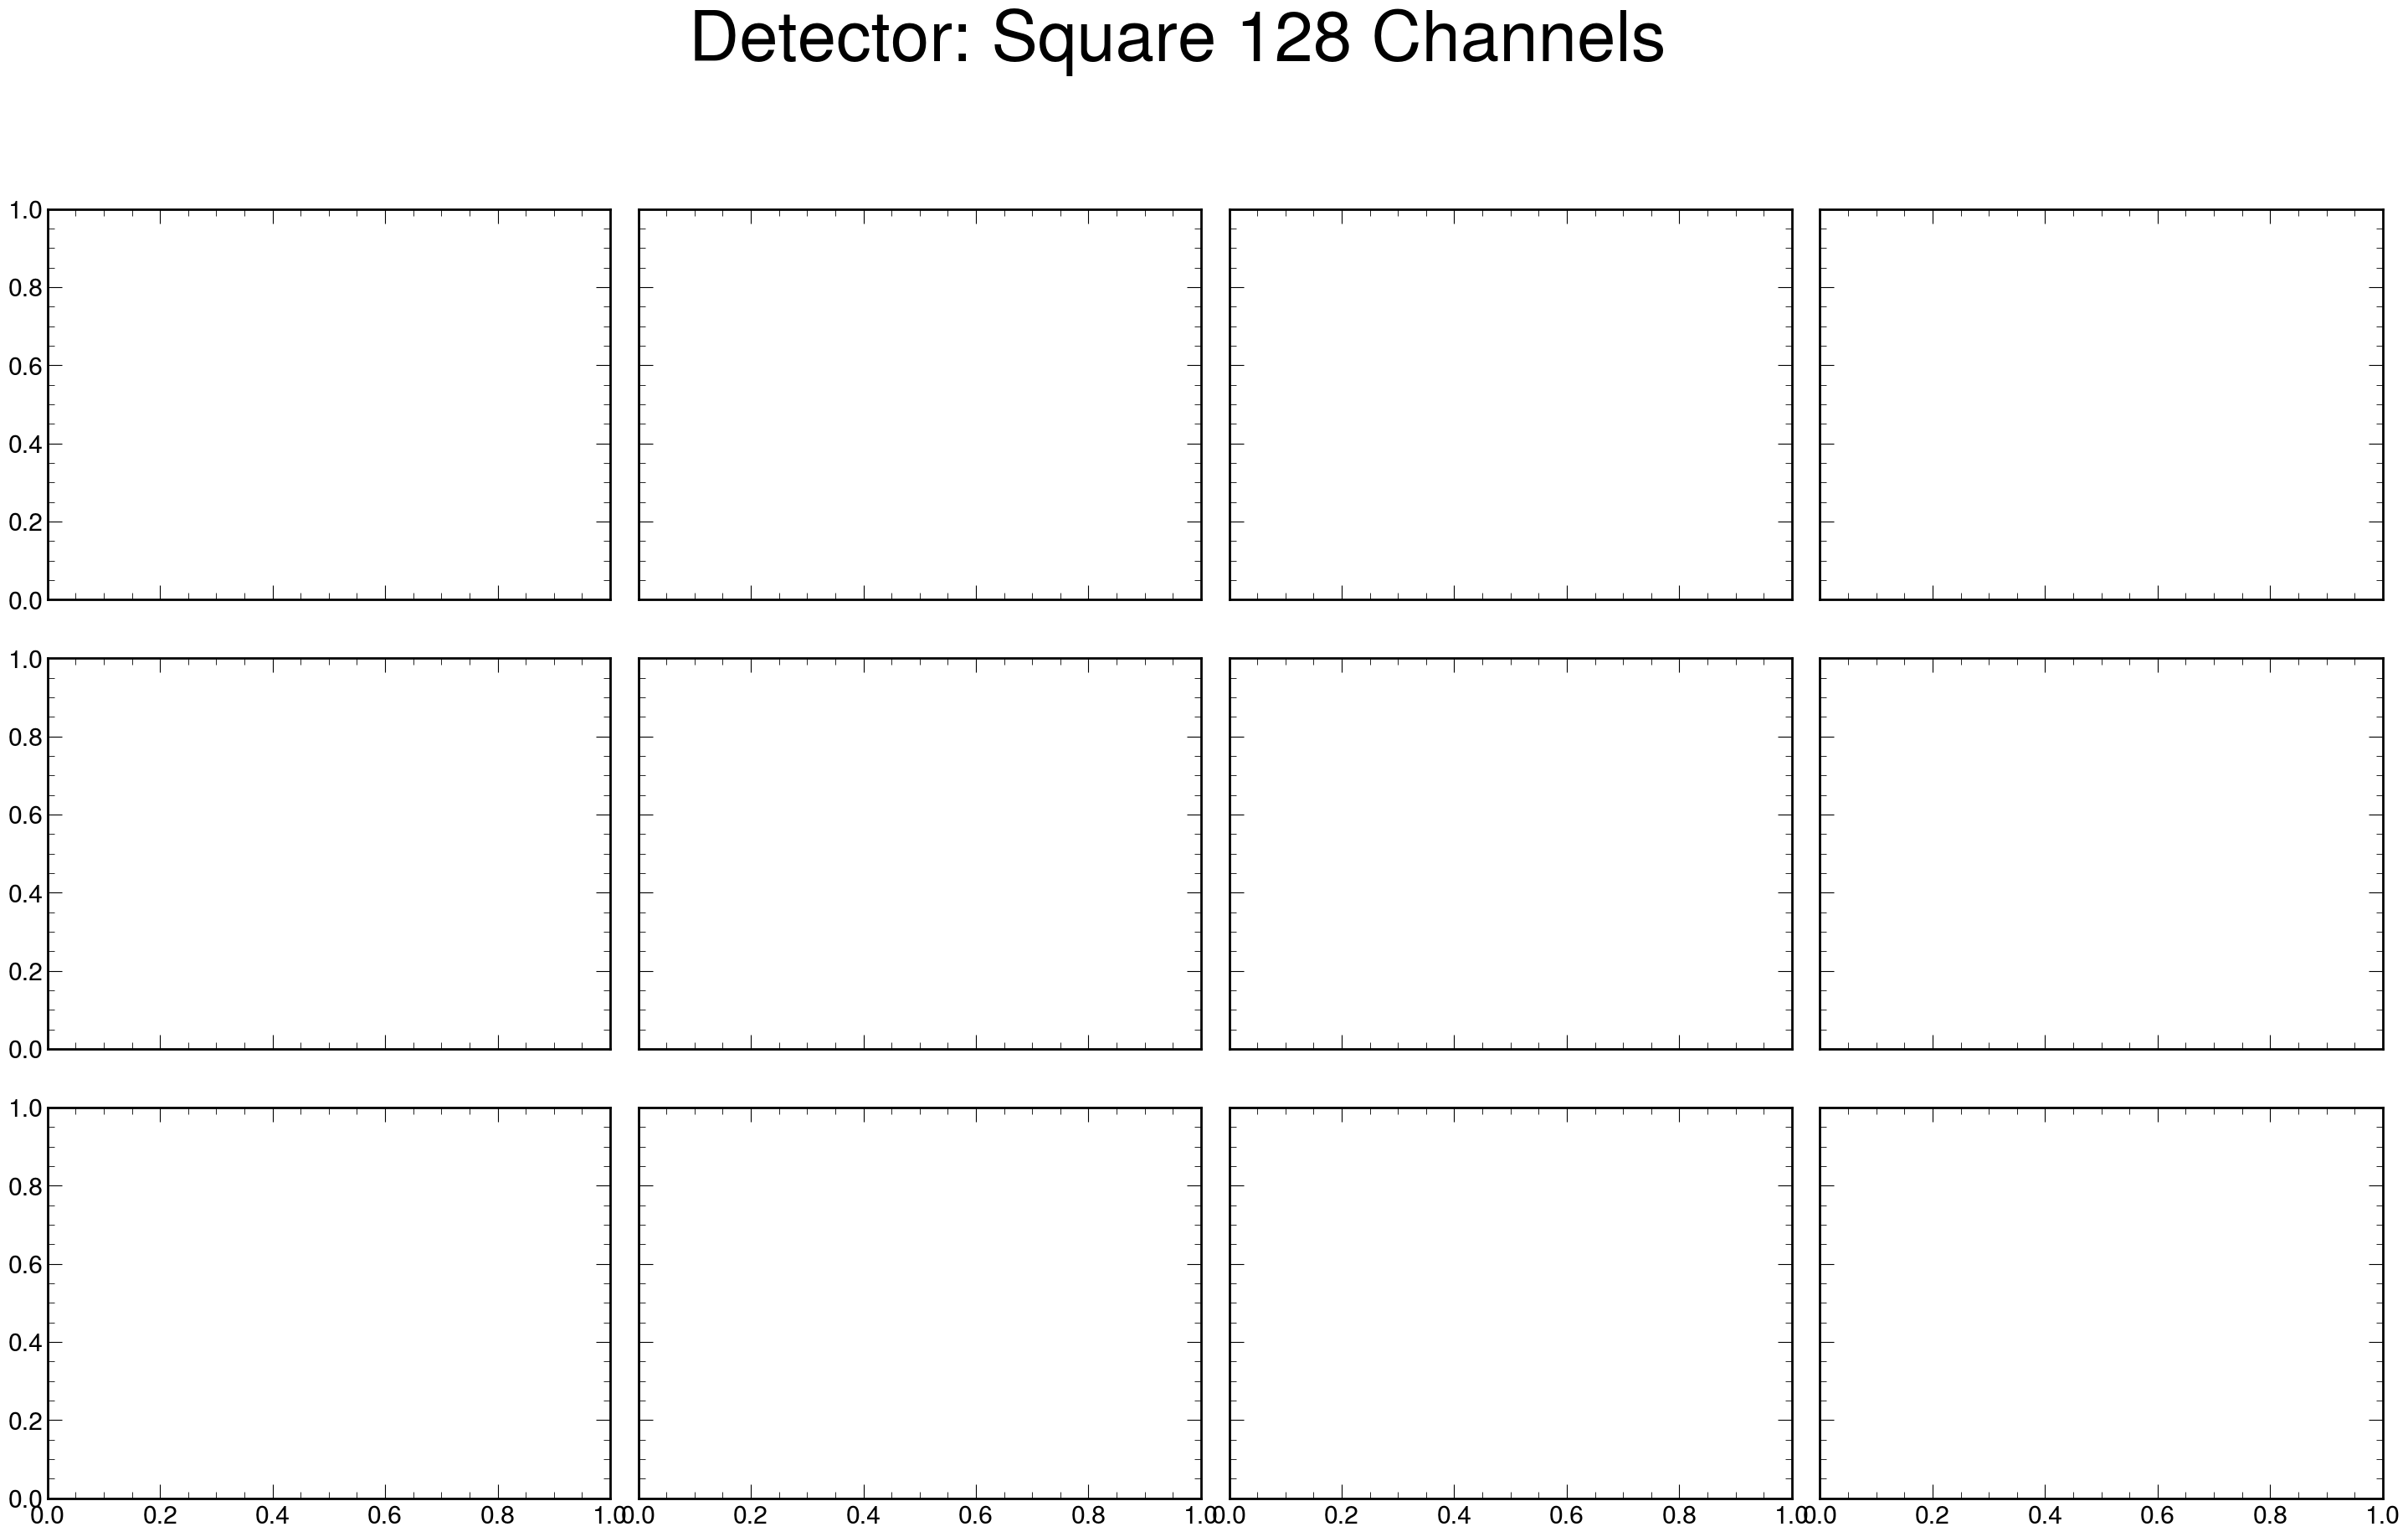

In [10]:


im_handles = [None, None, None]
theta_bin = np.linspace(5, 65, 15)
phi_bin = np.linspace(0, 360, 15)
num_bins = 10
num = 4
acceptance = 1.5
positions_x = [0,0,0,0]
positions_y = [0,0,0,0]
positions_z = [1,-25,-50,-100]

discrete_cmap = plt.cm.get_cmap('viridis', num_bins)
target_pos = [
    [50, 0, -20],
    [0, 20, -5],
    [5, 0, -5],
    [-10, 0, -35],
    [0,40,-65],
    [0,-60,-20]
]
radius = [20, 5, 5, 5, 10, 10]
fig, ax = plt.subplots(3, num, figsize=(9*num, 20), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.05, hspace=0.15)
plt.suptitle('Detector: Square 128 Channels', fontsize=60, y=1)
for i in range(num):
    det_pos = (positions_x[i], positions_y[i], positions_z[i])
    reco_data_angle = reco_data_angles[i]
    reco_sim_angle = reco_sim_angles[i]

    # Original 2D histograms
    T, xedges, yedges = np.histogram2d(
        np.mod(reco_sim_angle[:,1], 360), reco_sim_angle[:,0], 
        bins=[phi_bin, theta_bin], range=((0, 360),(10, 90))
    )

    H, _, _ = np.histogram2d(
        np.mod(reco_data_angle[:,1], 360), reco_data_angle[:,0], 
        bins=[phi_bin, theta_bin], range=((0, 360),(10, 90))
    )

    # --- Apply Auto-Poisson smoothing ---
    H_sm, sigma_opt_H, _ = smooth2d_auto(H)
    T_sm, sigma_opt_T, _ = smooth2d_auto(T)

    # 1) Statistical error (%)
    plt.sca(ax[0, i % num])
    error = 1 / np.sqrt(H.T) * 100
    im1 = plt.imshow(error, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                     cmap=cmap, aspect='auto', vmin=0, vmax=100)
    im_handles[0] = im1
    plt.ylim(top=63)
    plt.title(f'Detector {i}; {positions_x[i]},{positions_y[i]},{positions_z[i]} m')
    plt.colorbar(label='Statistical Error')

    # 2) Z-map
    plt.sca(ax[1, i % num])
    Z = poisson_to_Z(H_sm, T_sm)
    Z = np.clip(Z, -10, 10)
    im2 = plt.imshow(Z.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                     cmap='copper', aspect='auto', vmin=-5, vmax=5)
    im_handles[1] = im2
    plt.ylim(top=63)
    plt.title(f'Tar/Free Tracks: {len(reco_data_angle)}/{len(reco_sim_angle)}')
    plt.colorbar(label='Significance Z')

    # Overlay target positions
    for j, pos in enumerate(target_pos):
        rad, the, ph = project_point(radius[j], *pos, positions_x[i], positions_y[i], positions_z[i])
        circle = plt.Circle((np.mod(ph+180, 360), the), np.rad2deg(rad), color='red', fill=False,
                            linewidth=3, linestyle='--')
        if -5 < (ph+180) < 365 and -5 < the < 70:
            plt.text(np.mod(ph+180, 360), the, f'C{j}', size=20, c='r')
        ax[1, i % num].add_patch(circle)
    rad, the, ph = project_point(10,12,7,-25,positions_x[i],positions_y[i],positions_z[i])
    circle = plt.Circle((np.mod(ph+180, 360), the), np.rad2deg(rad), color='blue', fill=False, linewidth=3, linestyle='--')
    if -5<(ph+180)<365 and -5<the<70:
        plt.text(np.mod(ph+180, 360), the, f'B0', size=20, c='b')
    ax[1, i%num].add_patch(circle)
    
    # 3) Data / Simulation ratio
    plt.sca(ax[2, i % num])
    ratio = np.divide(H_sm, T_sm, out=np.zeros_like(H_sm), where=T_sm>0)
    im3 = plt.imshow(ratio.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                     aspect='auto', cmap='copper', vmin=0, vmax=2)
    im_handles[2] = im3
    plt.ylim(top=63)
    plt.colorbar(label='Transmission')
    plt.xlabel('Phi (degrees)', fontsize=35, labelpad=20)

    # Overlay same target positions on ratio plot
    for j, pos in enumerate(target_pos):
        rad, the, ph = project_point(radius[j], *pos, positions_x[i], positions_y[i], positions_z[i])
        circle = plt.Circle((np.mod(ph+180, 360), the), np.rad2deg(rad), color='red', fill=False,
                            linewidth=3, linestyle='--')
        if -5 < (ph+180) < 365 and -5 < the < 70:
            plt.text(np.mod(ph+180, 360), the, f'C{j}', size=20, c='r')
        ax[2, i % num].add_patch(circle)
    rad, the, ph = project_point(10,12,7,-25,positions_x[i],positions_y[i],positions_z[i])
    circle = plt.Circle((np.mod(ph+180, 360), the), np.rad2deg(rad), color='blue', fill=False, linewidth=3, linestyle='--')
    if -5<(ph+180)<365 and -5<the<70:
        plt.text(np.mod(ph+180, 360), the, f'B0', size=20, c='b')
    ax[2, i%num].add_patch(circle)
    
# Y-axis labels
ax[0, 0].set_ylabel('Theta (degrees)', fontsize=35, labelpad=20)
ax[1, 0].set_ylabel('Theta (degrees)', fontsize=35, labelpad=20)
ax[2, 0].set_ylabel('Theta (degrees)', fontsize=35, labelpad=20)

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


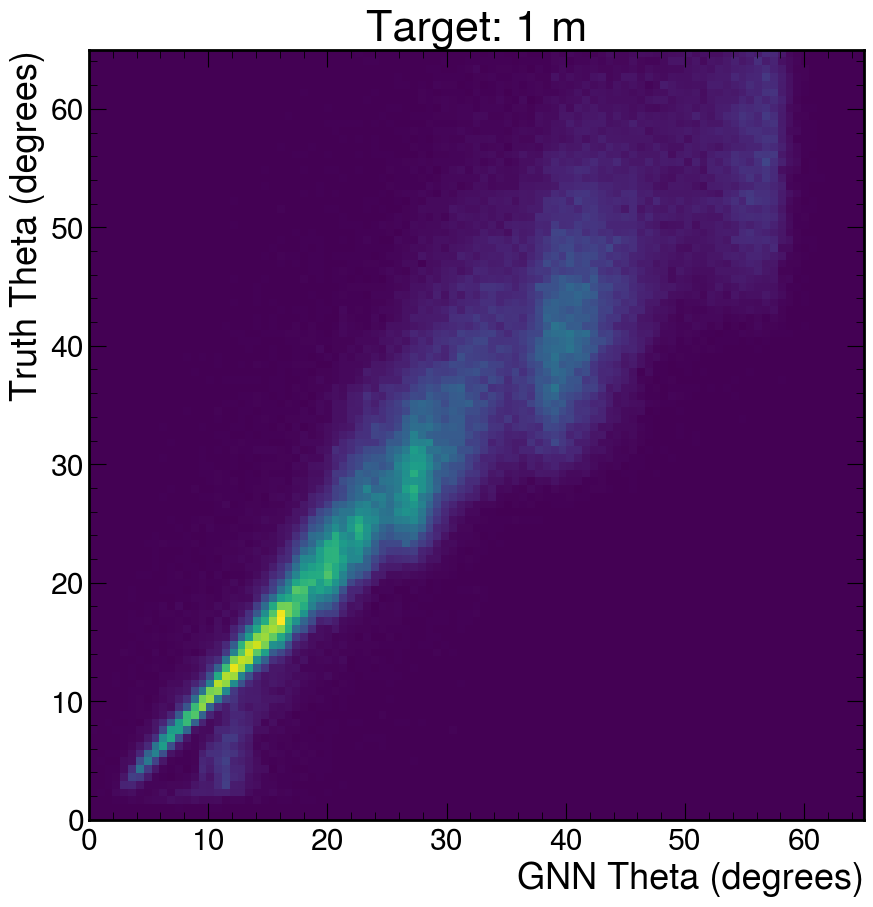

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


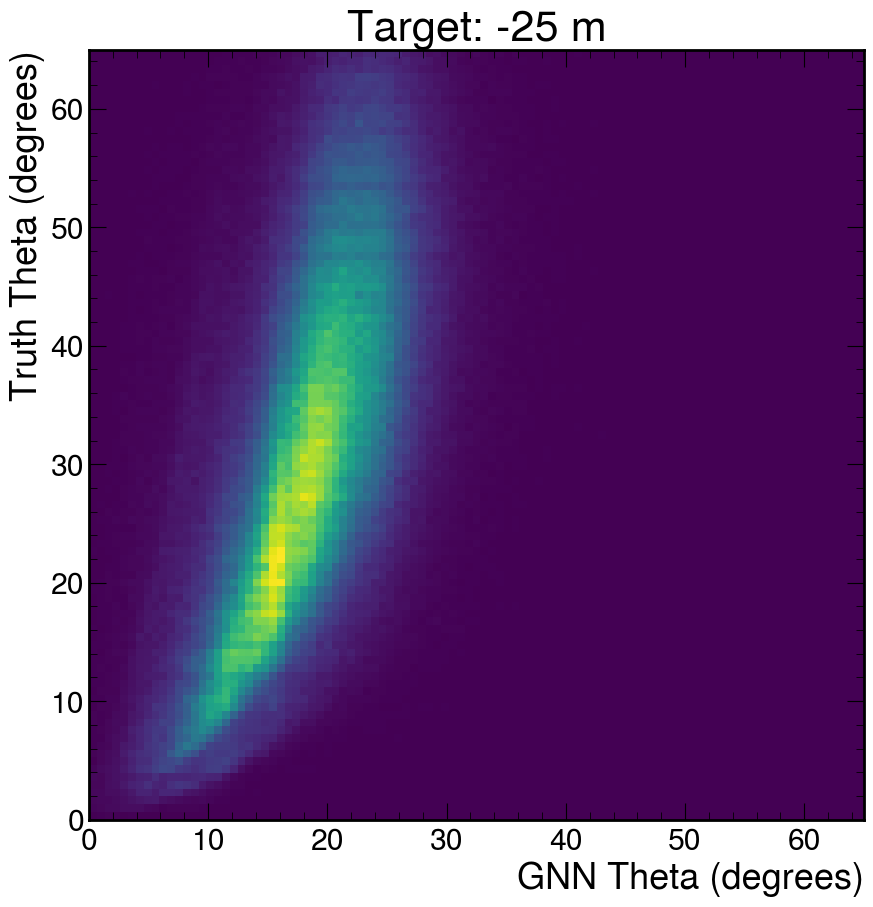

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


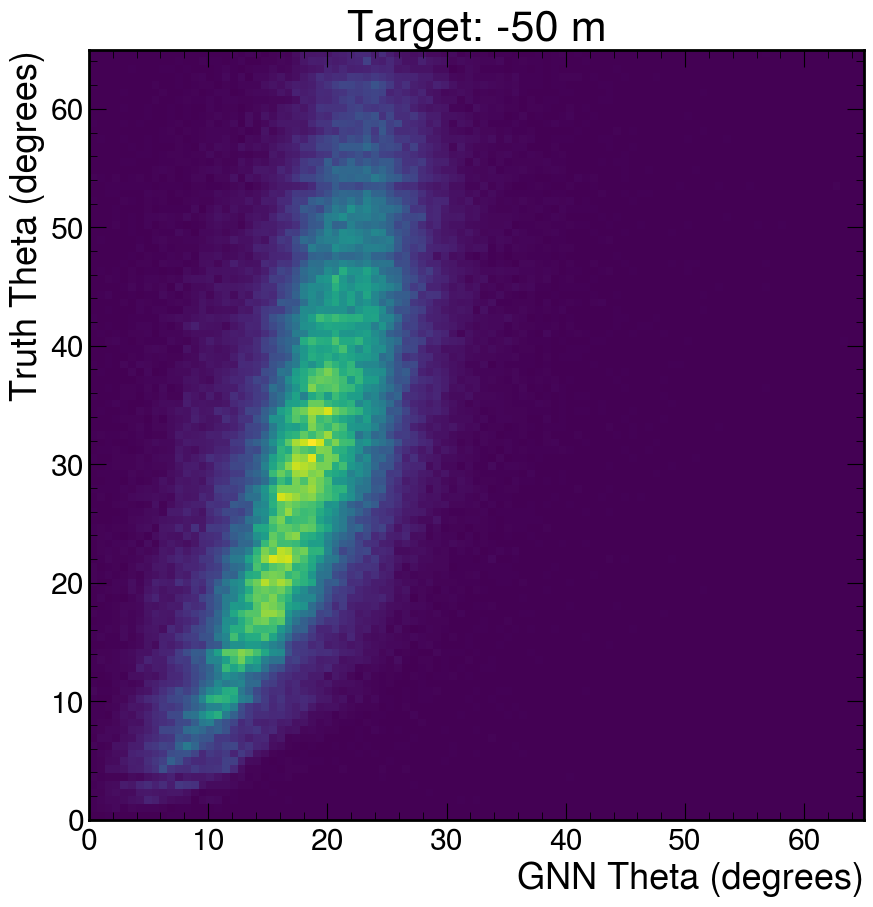

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


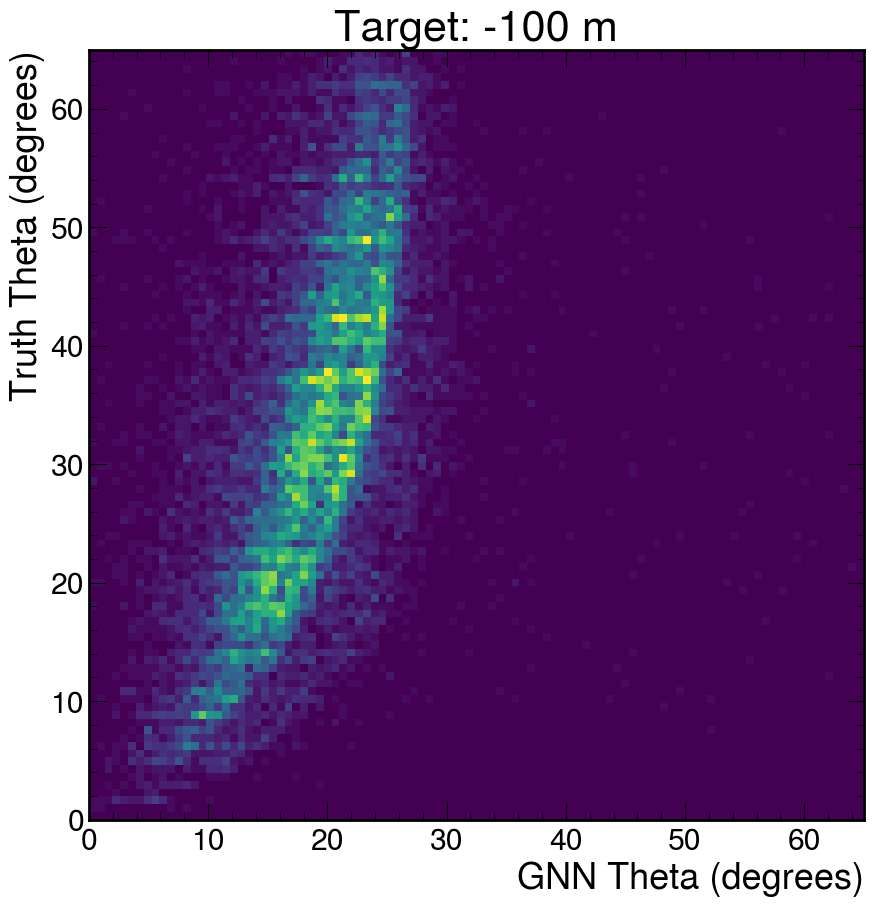

In [12]:
height = [1, -25, -50, -100]
for i in range(4):
    plt.hist2d(np.array(sim_GNN[i]),np.array(ak.flatten(sim_theta[i])),bins=[np.linspace(0,65,100),np.linspace(0,65,100)])
    plt.ylabel("Truth Theta (degrees)")
    plt.xlabel("GNN Theta (degrees)")
    plt.legend()
    plt.title(f'Target: {height[i]} m')
    plt.show()

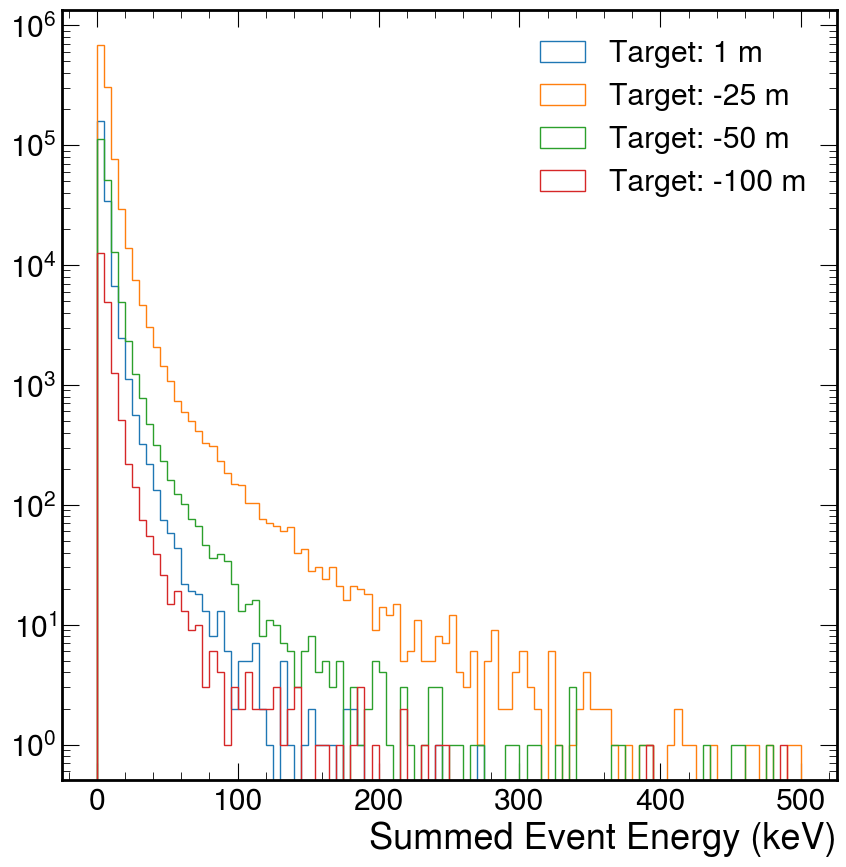

In [13]:
height = [1, -25, -50, -100]
for i in range(4):
    plt.hist(data_energies[i]*1000,bins=100,label=f'Target: {height[i]} m',histtype='step',range=(0,500))

plt.yscale('log')
plt.xlabel("Summed Event Energy (keV)")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


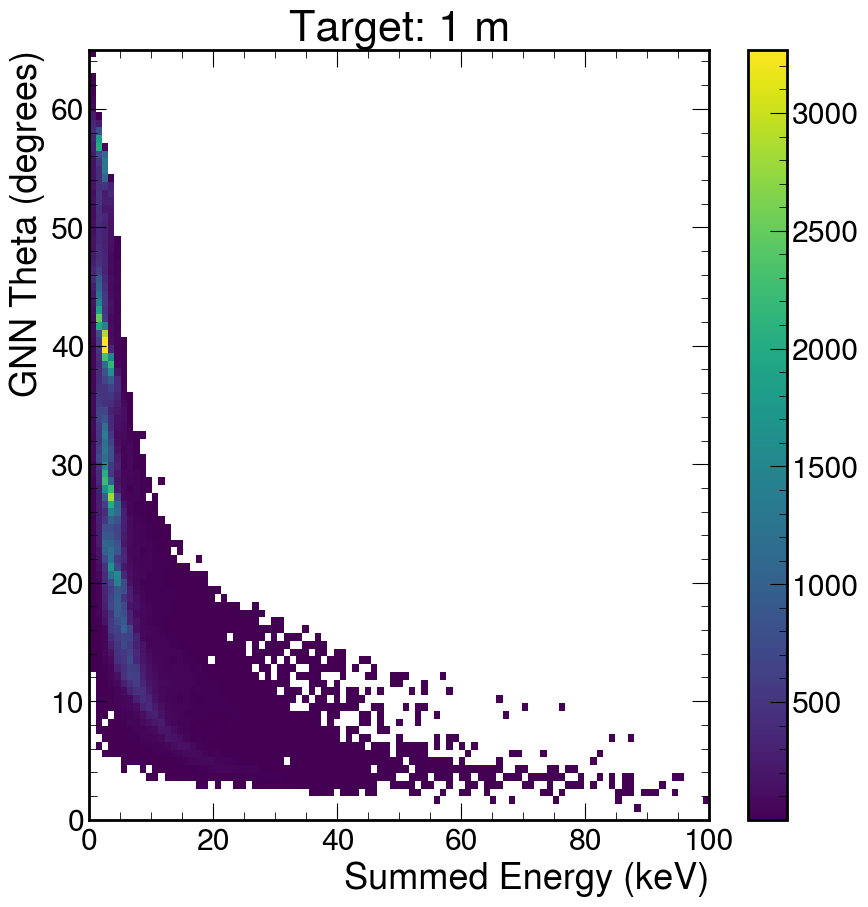

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


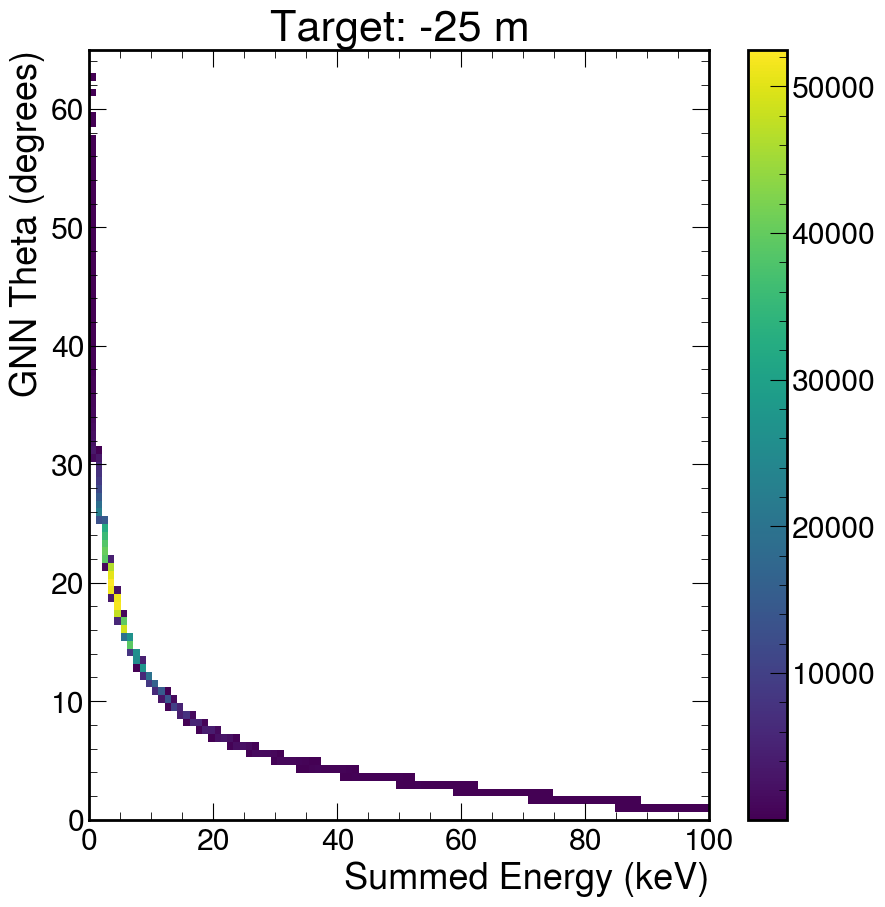

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


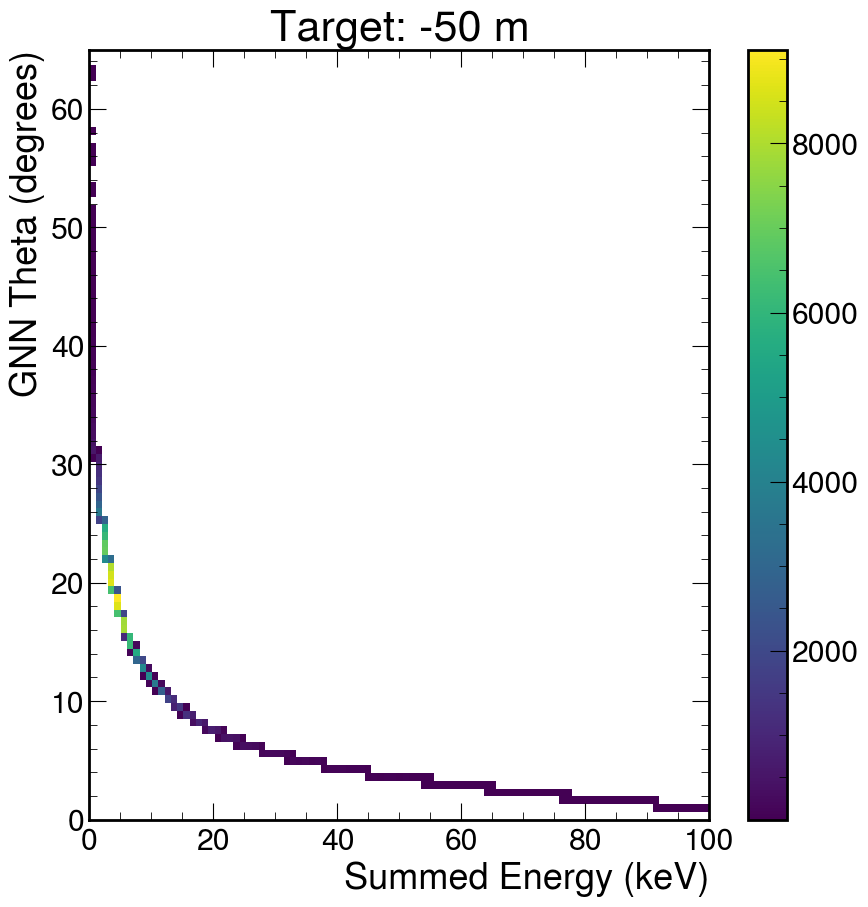

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


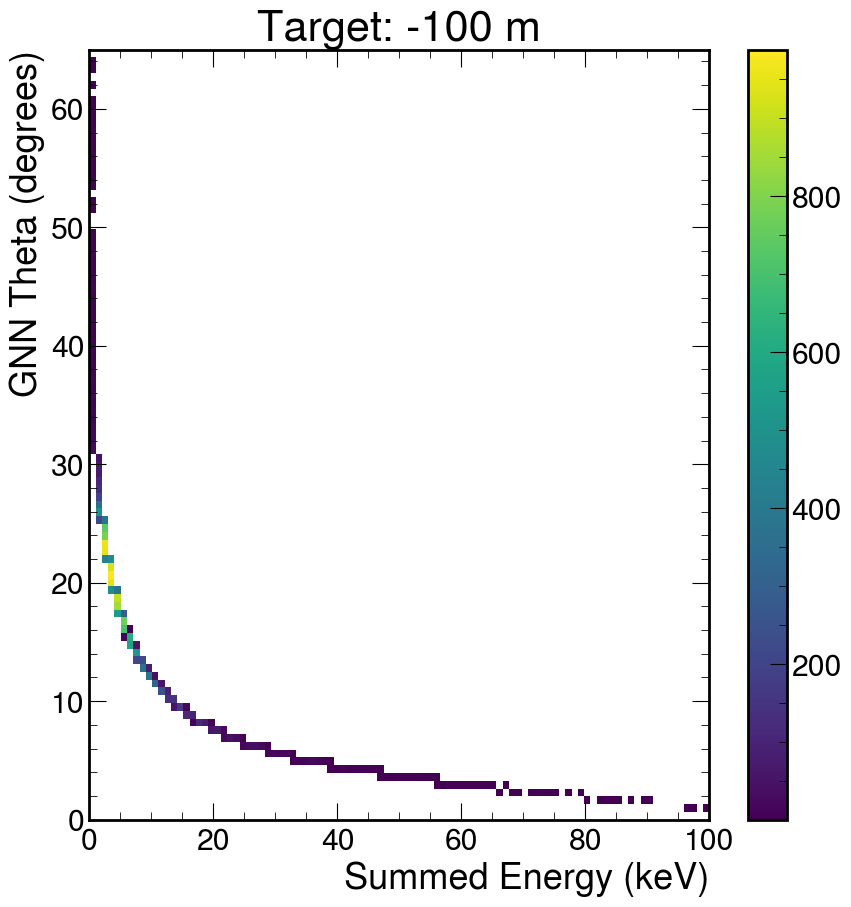

In [14]:
height = [1, -25, -50, -100]
energy_cut = [20,400,600,1500]
for i in range(4):
    plt.hist2d(np.array(data_energies[i])*1000,np.array(data_GNN[i]),bins=[np.linspace(0,100,100),np.linspace(0,65,100)],cmin=1)
    plt.ylabel("GNN Theta (degrees)")
    plt.xlabel("Summed Energy (keV)")
    plt.legend()
    plt.title(f'Target: {height[i]} m')
    plt.colorbar()
    plt.show()

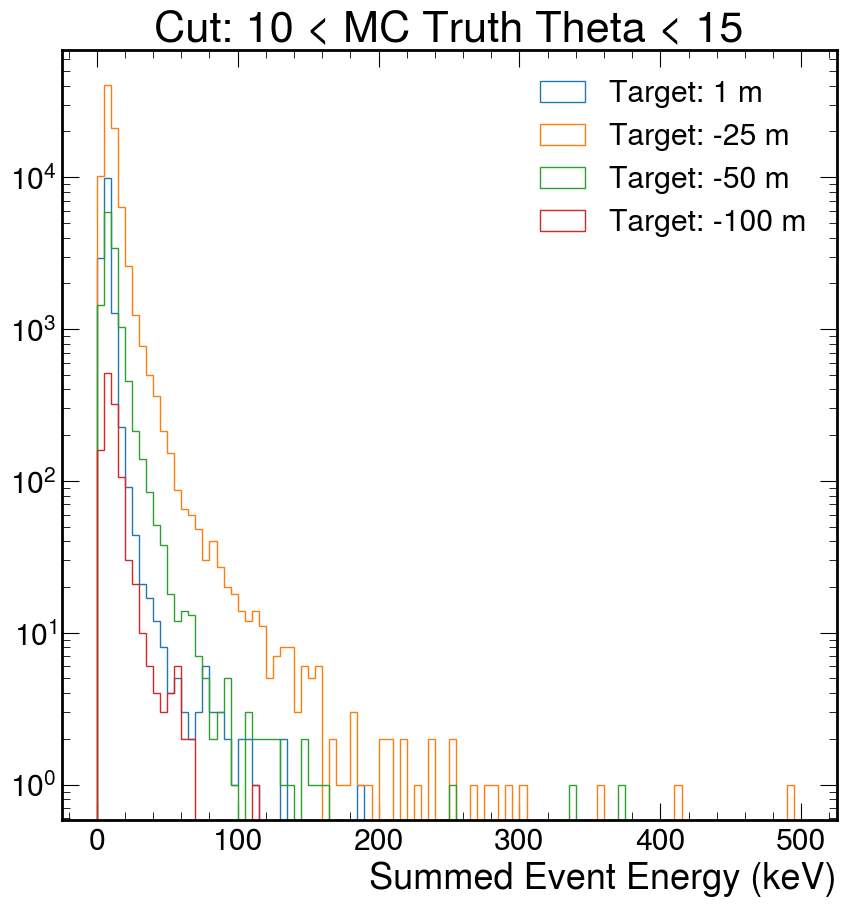

In [17]:
height = [1, -25, -50, -100]
for i in range(4):
    cut = ((10 <= np.array(np.concatenate(sim_theta[i]))) & (np.array(np.concatenate(sim_theta[i])) <= 15))
    plt.hist(sim_energies[i][cut]*1000,bins=100,label=f'Target: {height[i]} m',histtype='step',range=(0,500))
plt.title('Cut: 10 < MC Truth Theta < 15')
plt.yscale('log')
plt.xlabel("Summed Event Energy (keV)")
plt.legend()
plt.show()

In [19]:
array = {}
simfile = 'training/128_model/free_merged.root'
with uproot.open(simfile+":events") as f:
    array['muon_sim']=f.arrays(filter_name=["Detector", "MuographyHits.energy", "MuographyHits.energy_nonsmear"])
array['muon_sim']

<Array [{...}, {...}, {...}, ..., {...}, {...}] type='1650000 * {"Muography...'>

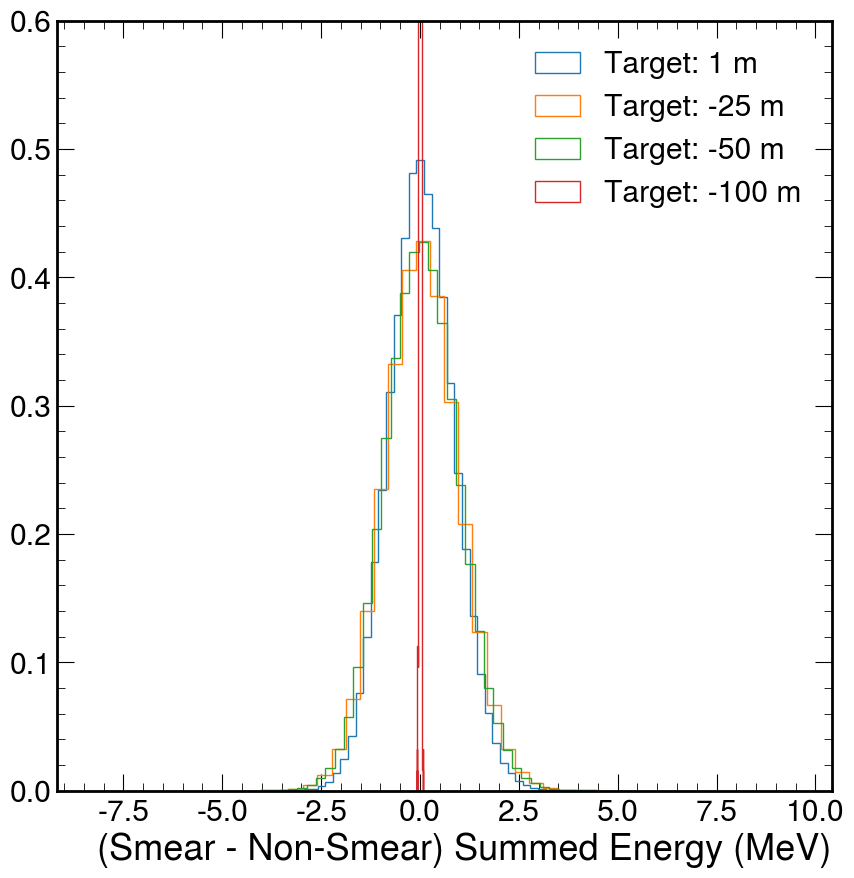

In [20]:
detectors = array['muon_sim']["Detector"]
smear_energy = ak.sum(array['muon_sim']["MuographyHits.energy"],axis=-1)*1000
nonsmear_energy = ak.sum(array['muon_sim']["MuographyHits.energy_nonsmear"],axis=-1)*1000
for i in range(4):
    plt.hist(smear_energy[detectors==i]-nonsmear_energy[detectors==i],bins=50,histtype='step',label=f'Target: {height[i]} m',density=True)
plt.ylim(0,0.6)
plt.xlabel('(Smear - Non-Smear) Summed Energy (MeV)')
plt.legend()
#plt.yscale('log')